# Download Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/My Drive/Copy of mscoco.zip" -d ./mscoco/

Streaming output truncated to the last 5000 lines.
  inflating: ./mscoco/mscoco/COCO_train2014_000000486641.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486713.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486717.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486718.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486732.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486793.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486807.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486821.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486854.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486869.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486870.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486906.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486936.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486960.jpg  
  inflating: ./mscoco/mscoco/COCO_train2014_000000486972.jpg  
  in

In [ ]:
! wget -q "https://drive.google.com/uc?export=download&id=1-3tnHTdDjtMd9O2LgKN2ir3t5KvnqrXI" -O dataset.zip
! unzip dataset.zip

Archive:  dataset.zip
  inflating: dataset/dataset.train.csv  
  inflating: dataset/dataset.valid.csv  


# Loading Data

## vocabulary class

In [ ]:
import nltk
from itertools import chain

nltk.download('punkt')
from collections import Counter

def tokenize(corpus):
    """ tokenizes the corpus and returns it as a list of list of tokens
    corpus: Input corpus as a list of sentences (each sentence is a string)
    """
    return [nltk.word_tokenize (c.lower()) for c in corpus]
# print (tokenize(["Hello world"]))

class Vocab:
    def __init__(self, word2id=None):
        """Constructor of Vocab

        word2id: dictionary that maps tokens to their ids.
        """
        self.pad_token = '<PAD>'
        self.end_token = '<END>'
        self.start_token = '<START>'
        self.unk_token = '<UNK>'

        if word2id is None:
            self.word2id = {self.pad_token: 0,
                            self.start_token: 1,
                            self.end_token: 2,
                            self.unk_token: 3}
            self.size = 4
        else:
            self.word2id = word2id
            self.size = len(self.word2id)

        self.id2word = {v: k for (k, v) in self.word2id.items()}

    def build(self, tokenized_corpus, size=None, min_freq=3):
        """Builds the vocab from a tokenized corpus.

        tokenized_corpus: corpus as a list of list of tokens (strings)
        size: Final size of (number of unique tokens in) our vocab
        min_freq: minimum frequency
        """
        tokens2freq = Counter(chain(*tokenized_corpus))  # dict that maps unique tokens to their freqs in the corpus
        
        frequent_tokens = []

        if min_freq is not None:
          # print ("applying min freq")
          tokens2freq = {k: tokens2freq[k] for k in tokens2freq.keys() if tokens2freq[k] > min_freq}

        if size is None:
          frequent_tokens = list (tokens2freq.keys())
          
        else:
          sorted_token2freq = {k: v for k, v in sorted(dict (tokens2freq).items(), key=lambda item: item[1] , reverse=True)}
          # print (sorted_token2freq)
          frequent_tokens = [k for i,k in enumerate (sorted_token2freq.keys()) if i < self.size ]
          
        # adding tokens to the vocab

        for token in frequent_tokens:
            self.add_token(token)
        
    def get_token_by_id(self, t_id: int) -> str:
        """Returns the token with the corresponding id in the vocab.
        If the id is not valid, returns None.

        t_id: token id
        """
        return self.id2word.get(t_id, None)

    def get_id_by_token(self, token: str) -> int:
        """Returns the id of the token in the vocab. If the token does not exist,
        returns the id of <UNK> token.

        token: token (as a string) for which the id should be returned.
        """
        return self.word2id.get(token, self.word2id[self.unk_token])

    def add_token(self, token: str):
        """Adds the token to the vocab's data structures
        token: token as a string
        """
        if not token in self.word2id.keys():
          self.word2id[token] = self.size
          self.id2word[self.size] = token
          self.size += 1
          
    def tokens2ids(self, sents):
        """Convert list of words or list of sentences of tokens 
        into list or list of list of indices.

        sents: input sentences as List[List[str]] (multiple sentences) or List[str]
        (single sentence)
        """
        self.word2id
        if type(sents[0]) == list:
            return [[self.word2id[word] if word in self.word2id.keys() else self.word2id[self.unk_token] for word in sent] for sent in sents]
        else:
            return [self.word2id[word] if word in self.word2id.keys() else self.word2id[self.unk_token] for word in sents]
  
    def to_tensor(self, sent):
        """Converts a sentence as a list of tokens into a tensor of indices.

        sent: a sentence as a list of strings (tokens)
        """
        return torch.tensor (self.tokens2ids(sent) , dtype = torch.long)


    def pad_sents(self, sents):
        """Pads list of sentences according to the longest sentence.

        sents: sentences as a list of list of tokens (strings).
        """
        sents_padded = []
        lengths = [len(v) for v in sents]
        ml = max (lengths)
        sents_padded = [v + [self.pad_token] * (ml - len(v)) for v in sents]
        return sents_padded

    def save(self, path: str):
        """Saves the vocab in a json file.

        path: path to save the vocab in
        """
        with open(path, 'w') as f:
            json.dump(self.word2id, f)

    @staticmethod
    def load(path: str):
        """Loads vocab from a json file.

        path: path to load the vocab from
        """
        with open(path, 'r') as f:
            word2id = json.load(f)

        return Vocab(word2id)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## CSV reader function

In [ ]:
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
import torch
import torchvision 
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt

def plot_tensor (tensor):
    plt.imshow (tensor.permute([1,2,0]))
    plt.show ()

def plot_box_on_tensor (source_tensor , box):
  source_img = torchvision.transforms.ToPILImage(mode='RGB')(source_tensor)
  x0, y0, W, H = box
  x1, y1 = x0 + W, y0 + H
  draw = ImageDraw.Draw(source_img)
  draw.rectangle([x0,y0,x1,y1], width=3)
  return torchvision.transforms.ToTensor ()(source_img)

def parse_box(box_str):
  a,b,c,d = box_str.split ("]")[0].split ("[")[1].split ()
  return float (a) , float(b), float(c), float(d)

def load_files(csv_name = "dataset.train.csv" , max_limit = None):
  train_set = []
  counter = 0
  print ("loading", csv_name)
  with open ("dataset/" + csv_name) as train_csv_file:
    
    line = next (train_csv_file)
    for line in tqdm (train_csv_file):
      counter += 1
      line = line.split ("\n")[0]
      
      file_id = line.split (",")[0]
      image_name = line.split (",")[1]
      text = (line.split ('"')[1]) if '"' in line else (line.split (',')[2])
      box = parse_box (line.split (",")[-1])
      
      train_set.append ({"image_name":image_name ,"box":box, "text":text, "id":file_id})
      if max_limit is not None and counter == max_limit:
            break
    
    return train_set
  


In [ ]:
train_data_set = load_files (csv_name = "dataset.train.csv", max_limit = None)
valid_data_set = load_files (csv_name = "dataset.valid.csv")

train_corpus = [d['text'] for d in train_data_set]

vocab = Vocab()
vocab.build (tokenize (train_corpus), min_freq = 3)
print ("vocab size:", vocab.size)

loading dataset.train.csv



loading dataset.valid.csv



vocab size: 3934


## dataset class

In [ ]:
def scale_and_pad(img, new_size = 224):
  min_dim = img.size.index (min(img.size))
  min_size = img.size[min_dim]
  max_dim = 1 - min_dim
  max_size = img.size[max_dim]

  unpadded_size = [new_size, new_size]
  unpadded_size[min_dim] = int (new_size/max_size * min_size)

  resized_image = torchvision.transforms.functional.resize(img, size = [unpadded_size[1] , unpadded_size[0]])

  new_w, new_h = resized_image.size
  
  pad_top = (new_size - new_h)//2 if new_h < new_size else 0
  pad_bottom = (new_size - new_h - pad_top) if new_h < new_size else 0

  pad_right = (new_size - new_w)//2 if new_w < new_size else 0
  pad_left = (new_size - new_w - pad_right) if new_w < new_size else 0
    
  pad_value = 0 #int (torchvision.transforms.functional.to_tensor(resized_image).mean().item() * 255)

  img_padded = torchvision.transforms.functional.pad (resized_image, padding = (pad_left, pad_top, pad_right, pad_bottom), fill= pad_value, padding_mode='constant')
  
  return img_padded

def check_iou(boxA , boxB , th = 0.3):
    x0A, y0A, x1A, y1A = boxA
    x0B, y0B, x1B, y1B = boxB

    sA = (x1A - x0A)*(y1A - y0A)
    sB = (x1B - x0B)*(y1B - y0B)

    x0 = max (x0A, x0B)
    x1 = min (x1A, x1B)

    y0 = max (y0A, y0B)
    y1 = min (y1A, y1B)

    s_inter = (y1-y0) * (x1-x0)
    if (y1-y0) < 0 or (x1-x0) < 0:
        s_inter = 0
    s_union = sA + sB - s_inter
    IoU = s_inter/s_union
#     print ("IOU:" , IoU)
    if IoU > th:
        return False
    else:
        return True

def crop_image(original_image , box):
    x0 , y0, W, H = box
    return torchvision.transforms.functional.crop(original_image, top = int (y0), left = int (x0), height = int (H), width = int (W))
    

class ImageCaptioningDataset(torch.utils.data.Dataset):
    def __init__(self, data_set, vocab, isValid = False):
      self.dataset = data_set
      assert vocab is not None
      self.vocab = vocab
      self.regions = None
      self.negative_box_output = False
      self.isValid = isValid
    
    def cache_region_proposals(self, faster_model = None):
      if self.regions is not None:
            return
      file_name = 'regions_valid.pickle' if self.isValid else 'regions.pickle'
#       print (os.path.isfile('regions.pickle'))
      if os.path.isfile(file_name):
        with open(file_name, 'rb') as f:
          self.regions = torch.load(f)
        return
      if faster_model is None:
        faster_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(DEVICE)
        faster_model = faster_model.to(DEVICE)
        faster_model.eval()
      
      regions = {}
      print ("running faster rcnn on dataset, be patient ...")
      for data in tqdm (self.dataset):
        image_name = data['image_name']
        original_image = Image.open("mscoco/mscoco/" + image_name).convert(mode="RGB")
        original_image_tensor = torchvision.transforms.ToTensor()(original_image)
        with torch.no_grad():
          output = faster_model(original_image_tensor[None].to(DEVICE))
          output = output[0]
          output['boxes'] = output['boxes'].cpu()
          output['labels'] = output['labels'].cpu()
          output['scores'] = output['scores'].cpu()
          regions[image_name] = output
      self.regions = regions
    
      with open(file_name, 'wb') as f:
        torch.save(self.regions, f)            
          
    def enable_comprehension_mode(self): 
        self.negative_box_output = True
        self.cache_region_proposals()
        
    def disable_comprehension_mode(self): 
        self.negative_box_output = False
        self.regions = None
    
    def get_one_candidate_box(self, image_name, positive_box, image_size):
      x0 , y0, W, H = positive_box
      positive_box = [x0, y0, x0+W, y0+H]
      regions = self.regions[image_name]['boxes']
      IOU_Th = 0.7
      IOU_mask = [check_iou(box, positive_box , th = IOU_Th) for box in regions]
      regions = regions[IOU_mask]
      if len (regions) > 0:
          
          random_num = torch.randint(low=0, high = len (regions) , size = [1]).item()
          negative_box = regions[random_num]
          x0 , y0, x1, y1 = negative_box
      else:
        print ("faster network failure")
        image_w, image_h = image_size        
        while True:
            x0 = torch.randint (low = 0, high = image_w, size = [1]).item()
            y0 = torch.randint (low = 0, high = image_h, size = [1]).item()
            x1 = torch.randint (low = 0, high = image_w, size = [1]).item()
            y1 = torch.randint (low = 0, high = image_h, size = [1]).item()
            box = [x0,y0,x1,y1]
            if x0 < x1 and y0 < y1 and check_iou(box, positive_box , th = IOU_Th):
                break
        print ([x0,y0,x1,y1] , positive_box)                
        
      W = x1 - x0
      H = y1 - y0
      negative_box = x0 , y0 , W, H                
      return negative_box
        
    def __getitem__(self, index):
      data = self.dataset[index]
      # {"image_name":image_name ,"box":box, "text":text, "id":file_id}
      text = data["text"]
      box = data['box']        
      image_name = data['image_name']
#       print (image_name)
      original_image = Image.open("mscoco/mscoco/" + image_name).convert(mode="RGB")
        
      
      cropped_img = crop_image (original_image, box)

      scaled_img_tensor = torchvision.transforms.ToTensor() (scale_and_pad (original_image))
      scaled_cropped_img_tensor = torchvision.transforms.ToTensor() (scale_and_pad (cropped_img))
      
      original_image_tensor = torchvision.transforms.ToTensor()(original_image)
      
    
      original_data = {'box':box, 'text':text, 'original_img_tensor':original_image_tensor, 'scaled_img_tensor':scaled_img_tensor, 'scaled_cropped_img_tensor':scaled_cropped_img_tensor}
      tokenized_text = ['<START>'] + tokenize([text])[0] + ['<END>']

    
      if self.negative_box_output:
        neg_box = self.get_one_candidate_box(image_name, box , original_image.size)
        cropped_img = crop_image (original_image, neg_box)
        
        neg_scaled_cropped_img_tensor = torchvision.transforms.ToTensor() (scale_and_pad (cropped_img))
        original_data['neg_box'] = neg_box
        
      original_image.close(), cropped_img.close()
      del original_image, cropped_img
      
      if self.negative_box_output:
          return original_data, scaled_img_tensor, scaled_cropped_img_tensor, tokenized_text, neg_scaled_cropped_img_tensor
      else:
          return original_data, scaled_img_tensor, scaled_cropped_img_tensor, tokenized_text

    def __len__(self):        
        return len (self.dataset)

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#fixme
train_dataset = ImageCaptioningDataset(train_data_set, vocab = vocab, isValid = False)
valid_dataset = ImageCaptioningDataset(valid_data_set, vocab = vocab, isValid = True)

# train_dataset, _ = torch.utils.data.random_split(train_dataset, [8, len (train_dataset) - 8])

def collate_fn(batch):
  original_datas = [b[0] for b in batch]
  scaled_img_tensors = torch.stack ([b[1] for b in batch])
  scaled_cropped_img_tensors = torch.stack ([b[2] for b in batch])
  tokenized_text = [b[3] for b in batch]
  target_tensors = vocab.to_tensor(vocab.pad_sents(tokenized_text)).transpose (0,1)
      
  if len(batch[0]) == 5:
    neg_scaled_cropped_img_tensors = torch.stack ([b[4] for b in batch])
    return original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors, neg_scaled_cropped_img_tensors
  else:
    return original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors



train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers = 0, shuffle=True , collate_fn = collate_fn, drop_last = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, num_workers = 0, shuffle=False, collate_fn = collate_fn, drop_last = False)


## testing captioning mode

Text: Skateboarding teen wearing a brown beanie
Text tensor: tensor([   1,  562, 3394,   43,    4,   81, 2453,    2,    0,    0,    0,    0,
           0,    0,    0,    0])
Original image:


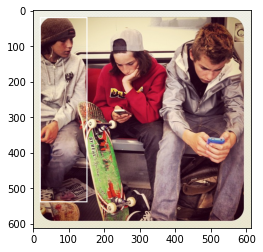

scaled image:


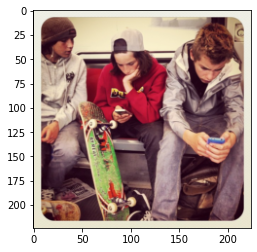

scaled crop:


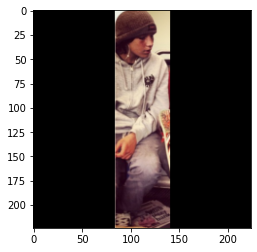

In [ ]:
train_dataset.disable_comprehension_mode()
valid_dataset.disable_comprehension_mode()

counter = 0 
for batch in train_dataloader:
  original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors = batch
  break

original_img = original_datas[0]['original_img_tensor']
box = original_datas[0]['box']
text = original_datas[0]['text']

print ("Text:" , text)
print ("Text tensor:" , target_tensors[:,0])
print ("Original image:")
plot_tensor(plot_box_on_tensor(original_img, box))
print ("scaled image:")
plot_tensor(scaled_img_tensors[0])
print ("scaled crop:")
plot_tensor(scaled_cropped_img_tensors[0])


## testing comprehension mode

In [ ]:
train_dataset.enable_comprehension_mode()
valid_dataset.enable_comprehension_mode()

counter = 0 
for batch in train_dataloader:
  original_datas, scaled_img_tensors, scaled_cropped_img_tensors, target_tensors, negative_scaled_cropped_img_tensors= batch
  break

original_img = original_datas[0]['original_img_tensor']
box = original_datas[0]['box']
neg_box = original_datas[0]['neg_box']
text = original_datas[0]['text']

print ("Text:" , text)
print ("Text tensor:" , target_tensors[:,0])
print ("Original image + postitive and negative boxes:")
plot_tensor(plot_box_on_tensor(plot_box_on_tensor(original_img, neg_box), box))
print ("scaled image:")
plot_tensor(scaled_img_tensors[0])
print ("scaled crop:")
plot_tensor(scaled_cropped_img_tensors[0])
print ("negative scaled crop:")
plot_tensor(negative_scaled_cropped_img_tensors[0])


# Model

## Attention Model

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

#overwriting forward function
class CustomResnet(nn.Module):
    def forward(self, x):
        resnet = self.resnet
        x = resnet.conv1(x)
        x = resnet.bn1(x)
        x = resnet.relu(x)
        x = resnet.maxpool(x)

        x = resnet.layer1(x)
        x = resnet.layer2(x)
        x = resnet.layer3(x)
        x_middle = resnet.layer4(x)

        x = resnet.avgpool(x_middle)
        x = torch.flatten(x, 1)
        x = resnet.fc(x)

        return x, self.conv_last (x_middle)
    
    def __init__(self):
        super(CustomResnet, self).__init__()
        resnet = models.resnet50(pretrained=True)
        self.resnet = resnet
        self.conv_last = nn.Conv2d (2048 , 512, (1,1))
#         del self.resnet.fc, self.resnet.avgpool

#         for a in self.resnet.parameters():
#           a.requires_grad_(False)
        

class ImageCaptionerModel_attn(nn.Module):
    def get_feature_extractor (self, input_image_size):
        self.resnet = CustomResnet()
        # models.vgg19_bn(pretrained=True).features
        feature_extracotor = self.resnet
        x, x_mid = feature_extracotor (torch.rand (*[1, 3, 224 , 224]))

        features_size = x_mid[0].shape
        
        return feature_extracotor, features_size


    def __init__(self, vocab = None, input_image_size = 224):
        super(ImageCaptionerModel_attn, self).__init__()
        
        self.cnn_feature_extractor, features_size = self.get_feature_extractor (input_image_size)
        # print ("Features size= ", features_size)

        
        self.HW = features_size[1] * features_size[2]
        self.C = features_size[0]
        self.hidden_size = self.C
        self.embeding_size = 512
        self.encoder_output_size = 2000
        
        self.vocab = vocab

        self.embedding = torch.nn.Embedding(num_embeddings = vocab.size, embedding_dim = self.embeding_size, padding_idx=vocab.word2id[vocab.pad_token])
        self.rnn = nn.GRUCell (input_size = 2 * self.C + self.embeding_size, hidden_size=self.hidden_size)
        self.bridge = nn.Linear(self.encoder_output_size , self.hidden_size , bias = True)
        self.output_projection = nn.Linear (self.hidden_size, vocab.size, bias=False)
        self.attn_combine = torch.nn.Linear( 2 * self.C + self.hidden_size , self.hidden_size, bias=False)
        self.dropout = torch.nn.Dropout (0.3)
    
    
    
    def initialize_hiddens(self, context_features_flat, crop_features_flat):
      batch_size = context_features_flat.shape[0]
      init_hidden_states = self.dropout (self.bridge (torch.cat ([context_features_flat, crop_features_flat], dim = -1)))
      # print ("init hiddens :", init_hidden_states.shape)
      return init_hidden_states



    def get_logits(self, context_features_flat, crop_features_flat, context_features, crop_features, sentences, init_hidden_states = None):
      batch_size = context_features.shape[0]
    
      if init_hidden_states is None:
        init_hidden_states = self.initialize_hiddens(context_features_flat, crop_features_flat)
      dec_state = init_hidden_states
      
      combined_output_prev = torch.cat ([context_features.mean(-1), crop_features.mean(-1)] , dim = -1)  
      
      embedded_sents = self.embedding (sentences)
      # print ("combined_output_prev.shape" , combined_output_prev.shape)
      combined_outputs = []
    
      for t, y_t in enumerate (embedded_sents):
#         print ("y_t:" , y_t.shape)
        ybar_t = torch.cat ((y_t, combined_output_prev) , dim = -1)
        dec_state , combined_output_prev = self.step(ybar_t , dec_state, context_features, crop_features)
        combined_outputs.append (dec_state)

      combined_outputs = torch.stack (combined_outputs)
      logits = self.output_projection (combined_outputs)
      return logits, dec_state

    def forward(self, x):
      DEVICE = next (self.parameters()).device
      
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)
      full_sentences = x[2].to(DEVICE)

      sentences = full_sentences[:-1] 
      
      B = cropped_image_tensor.shape[0]

      context_features_flat, context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features_flat, crop_features = self.cnn_feature_extractor(cropped_image_tensor)
      
      context_features = context_features.reshape (B, self.C, self.HW)
      crop_features = crop_features.reshape (B, self.C, self.HW)
        
      logits, _ = self.get_logits(context_features_flat, crop_features_flat, context_features, crop_features, sentences)

      sent_mask = (full_sentences != self.vocab.word2id[self.vocab.pad_token]).float()

      log_probs = F.log_softmax(logits, dim=-1)
      # Compute log probability of generating true target words
      tgt_gold_words_log_prob = torch.gather(log_probs, index=full_sentences[1:].unsqueeze(-1), dim=-1).squeeze(-1) * sent_mask[1:]

      # sum scores across different time steps of sequences (i.e. computing log probability of the sequences)
      scores = tgt_gold_words_log_prob.sum(dim=0)
      
      return scores
     

    def step(self, ybar_t, dec_state, context_features, crop_features):
        
        dec_state_t = self.rnn(ybar_t,dec_state)
        
#         print ("dec_state_t:", dec_state_t.shape)
#         print ("context_features:", context_features.shape)
#         print ("crop_features:", crop_features.shape)

        context_attn_scores_t = torch.bmm (dec_state_t[:,None,:], context_features)
        crop_attn_scores_t    = torch.bmm (dec_state_t[:,None,:], crop_features)

        context_attn_dist = torch.nn.Softmax(dim=-1)(context_attn_scores_t)
        crop_attn_dist    = torch.nn.Softmax(dim=-1)(crop_attn_scores_t)

        # print ("context_attn_dist:", context_attn_dist.shape)
        # print ("crop_attn_dist:", crop_attn_dist.shape)

        attended_context_features = (context_features * context_attn_dist).sum(dim = -1)
        attended_crop_features    = (crop_features    * crop_attn_dist).sum(dim = -1)
        
        # print ("attended_context_features:", attended_context_features.shape)
        # print ("attended_crop_features:", attended_crop_features.shape)
        
        concated_tensor = torch.cat((attended_context_features, attended_crop_features) , dim = -1)
        return dec_state_t, concated_tensor
    
    def decode_beam(self, beam, context_features_flat, crop_features_flat, context_features, crop_features, k):
        hidden_state = beam['last_hidden']
        word = torch.tensor ([beam['words'][-1]])
        sentences = word[None].to(DEVICE)
#         print ("Beam2:", context_features[0,:5])
        logits, _ = self.get_logits(context_features_flat, crop_features_flat, context_features, crop_features, sentences, hidden_state)        

#         print ("beam logits", logits[:,:,:3], hidden_state[0,0,:3])
#         print (1/0)
        probs = logits.softmax(dim=-1)
        probs, idxs = torch.topk (probs, k)
        probs = probs.reshape([k])
        idxs = idxs.reshape([k])
        
        res = []
        for i in range(probs.shape[0]):
            res.append({"last_hidden":hidden_state, "prob": probs[i].item() * beam['prob'] , "words": beam['words']+[idxs[i].item()]})
        return res

    def BeamDecode (self, x, max_length = 10, k = 5):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
      B = cropped_image_tensor.shape[0]
        
      context_features_flat, context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features_flat, crop_features = self.cnn_feature_extractor(cropped_image_tensor)
      
      context_features = context_features.reshape (B, self.C, self.HW)
      crop_features = crop_features.reshape (B, self.C, self.HW)
        
      word = self.vocab.to_tensor([self.vocab.start_token]).item()
      
      beams_queue = [{"words": [word], "prob": 1, "last_hidden": None}]
      completed_beams = []
      beam_size = k
      
      for i in range (max_length):
        new_beams_queue = []
        for beam in beams_queue:
            new_beams_queue += self.decode_beam (beam, context_features_flat, crop_features_flat, context_features, crop_features, k)
        
        beams_queue = sorted(new_beams_queue, key=lambda x: x['prob'], reverse=True)[:beam_size]
        next_beams_queue = []
        for j in range(len(beams_queue)):
          if not (beams_queue[j]['words'][-1] == self.vocab.to_tensor([self.vocab.end_token]).item()):
            next_beams_queue.append (beams_queue[j])
          else:
            beam_size -= 1
            completed_beams.append(beams_queue[j])
            
        beams_queue = next_beams_queue
            
        if (beam_size <= 0):
            break
      
    
      NO_END_FLAG = False
      if (len(completed_beams) == 0):
        completed_beams = beams_queue
        NO_END_FLAG = True
        
      sentence_list = max(completed_beams, key=lambda x: x['prob'])['words']      
#       beam_probs = torch.tensor ([completed_beams[t]['prob'] for t in range (len (completed_beams)) if t < 4])    
#       beam_candidates = torch.distributions.categorical.Categorical(logits=beam_probs)
#       sentence_list = completed_beams[beam_candidates.sample().item()]['words']
      
      sentence_list = sentence_list[1:] #removing start

      if not NO_END_FLAG:
        sentence_list = sentence_list[:-1] #removing stop token
      return [vocab.get_token_by_id(word) for word in sentence_list]


DEBUG_MODEL = True
if DEBUG_MODEL:
  DEVICE = 'cpu'
  model = ImageCaptionerModel_attn(vocab).to(DEVICE)
  a = model ([torch.rand (*[2, 3, 224 , 224])]*2 + [torch.randint(low = 0, high = vocab.size, size = [10, 2])])
  print (a.shape)

    


torch.Size([2])



## LSTM model

In [ ]:
class ImageCaptionerModel(nn.Module):
    def __init__(self, Vocab = None, input_image_size = 224):
        super(ImageCaptionerModel, self).__init__()
        
        
#         self.cnn_feature_extractor = models.vgg19_bn(pretrained=True)
        self.cnn_feature_extractor = models.resnet50(pretrained=True)
#         for a in self.cnn_feature_extractor.parameters():
#             a.requires_grad_(False)

        self.embeding_size = 512
        self.hidden_size = 512
        self.vocab = vocab
        self.input_size = 2000
        self.embedding = torch.nn.Embedding(num_embeddings = vocab.size, embedding_dim = self.embeding_size, padding_idx=vocab.word2id[vocab.pad_token])
        self.rnn = nn.LSTM(input_size= self.embeding_size + self.input_size, hidden_size = self.hidden_size, num_layers = 1, bias = True, )
        self.output_projection = nn.Linear (self.hidden_size, vocab.size, bias=False)
        self.dropout = torch.nn.Dropout (0.1)
        self.bridge = nn.Linear (self.input_size , self.hidden_size , bias = True)
        
    def initialize_hiddens(self, context_features, crop_features):
        
      batch_size = context_features.shape[0]
      init_hidden_states = [torch.zeros ([1,batch_size, self.hidden_size] , requires_grad = False).to(DEVICE),
                                  torch.zeros ([1,batch_size, self.hidden_size] , requires_grad = False).to(DEVICE)]      
      
      init_hidden_states[0] = self.dropout (self.bridge (torch.cat ([context_features, crop_features], dim = 1)[None]))
      return init_hidden_states
        
    def get_logits(self, context_features, crop_features, sentences, init_hidden_states = None ):  
      batch_size = context_features.shape[0]
    
      if init_hidden_states is None:
        init_hidden_states = self.initialize_hiddens(context_features, crop_features)

      embedded_sents = self.embedding (sentences)
      rnn_input = torch.cat([torch.cat ([context_features, crop_features], dim = 1)[None].expand(embedded_sents.shape[0],batch_size,crop_features.shape[-1] + context_features.shape[-1]),
                      embedded_sents] , dim = -1)      
    
      output, hiddens = self.rnn(rnn_input, init_hidden_states)
      logits = self.output_projection (output)
      return logits, hiddens

    def forward(self, x):
      DEVICE = next (self.parameters()).device        
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)
      full_sentences = x[2].to(DEVICE)         
        
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)   
        
      sentences = full_sentences[:-1] 
      logits, _ = self.get_logits(context_features, crop_features, sentences)
    
      sent_mask = (full_sentences != self.vocab.word2id[self.vocab.pad_token]).float()

      log_probs = F.log_softmax(logits, dim=-1)
      # Compute log probability of generating true target words
      tgt_gold_words_log_prob = torch.gather(log_probs, index=full_sentences[1:].unsqueeze(-1), dim=-1).squeeze(-1) * sent_mask[1:]

      # sum scores across different time steps of sequences (i.e. computing log probability of the sequences)
      scores = tgt_gold_words_log_prob.sum(dim=0)
      
      return scores
 
    
    
    def GreedyDecode(self, x, max_length = 10, temperature = 1):
      DEVICE = next (self.parameters()).device        
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
      
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
      print ("Greedy:", context_features[0,:5])
      hidden_state = None  

      word = self.vocab.to_tensor([self.vocab.start_token])
      words = []
      for t in range (max_length):
          sentences = word[None].to(DEVICE) #adding time and batch dims
          logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
          dist = torch.distributions.categorical.Categorical(probs=None, logits=logits[0,0]/temperature, validate_args=None)
#           print ("greedy logits", logits[:,:,:3], hidden_state[0,0,:3])
          word = torch.argmax (logits).item() #dist.sample().item()
          if self.vocab.get_token_by_id(word) == self.vocab.end_token:
            break
            
          words.append (vocab.get_token_by_id(word))
#           print (word, vocab.get_token_by_id(word))
          word = torch.tensor ([word])

            
      return words

    def decode_beam(self, beam, context_features, crop_features, k):
        hidden_state = beam['last_hidden']
        word = torch.tensor ([beam['words'][-1]])
        sentences = word[None].to(DEVICE)
#         print ("Beam2:", context_features[0,:5])
        
        logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
#         print ("beam logits", logits[:,:,:3], hidden_state[0,0,:3])
#         print (1/0)
        probs = logits.softmax(dim=-1)
        probs, idxs = torch.topk (probs, k)
        probs = probs.reshape([k])
        idxs = idxs.reshape([k])
        
        res = []
        for i in range(probs.shape[0]):
            res.append({"last_hidden":hidden_state, "prob": probs[i].item() * beam['prob'] , "words": beam['words']+[idxs[i].item()]})
        return res

    def BeamDecode (self, x, max_length = 10, k = 5):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
        
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
#       print ("Beam1:", context_features[0,:5])
      word = self.vocab.to_tensor([self.vocab.start_token]).item()
      
      beams_queue = [{"words": [word], "prob": 1, "last_hidden": None}]
      completed_beams = []
      beam_size = k
      
      for i in range (max_length):
        new_beams_queue = []
        for beam in beams_queue:
            new_beams_queue += self.decode_beam (beam, context_features, crop_features, k)
        
        beams_queue = sorted(new_beams_queue, key=lambda x: x['prob'], reverse=True)[:beam_size]
        next_beams_queue = []
        for j in range(len(beams_queue)):
          if not (beams_queue[j]['words'][-1] == self.vocab.to_tensor([self.vocab.end_token]).item()):
            next_beams_queue.append (beams_queue[j])
          else:
            beam_size -= 1
            completed_beams.append(beams_queue[j])
            
        beams_queue = next_beams_queue
            
        if (beam_size <= 0):
            break
      
    
      NO_END_FLAG = False
      if (len(completed_beams) == 0):
        completed_beams = beams_queue
        NO_END_FLAG = True
        
      sentence_list = max(completed_beams, key=lambda x: x['prob'])['words']      
#       beam_probs = torch.tensor ([completed_beams[t]['prob'] for t in range (len (completed_beams)) if t < 4])    
#       beam_candidates = torch.distributions.categorical.Categorical(logits=beam_probs)
#       sentence_list = completed_beams[beam_candidates.sample().item()]['words']
      
      sentence_list = sentence_list[1:] #removing start

      if not NO_END_FLAG:
        sentence_list = sentence_list[:-1] #removing stop token
      return [vocab.get_token_by_id(word) for word in sentence_list]

DEBUG_MODEL = True
if DEBUG_MODEL:
  DEVICE = 'cuda'
  with torch.no_grad():
      model = ImageCaptionerModel(Vocab = vocab).to(DEVICE)
      a = model ([torch.rand (*[2, 3, 224 , 224])]*2 + [torch.randint(low = 0, high = vocab.size, size = [10, 2])])
      x = [torch.rand (*[1, 3, 224 , 224])]*2
      sentence1 = model.GreedyDecode (x)
      sentence2 = model.BeamDecode   (x)
      sentence3 = model.BeamDecode   (x , k = 1)
      print (a.shape)
      print (" ".join(sentence1))
      print (" ".join(sentence2))
      print (" ".join(sentence3))

Greedy: tensor([-0.8879, -0.2205, -0.5600, -1.1264, -0.5496], device='cuda:0')
torch.Size([2])
curry starring spiral spot starring spiral spot legged hodling disposable
bluejeans starring spiral starring spiral starring spiral starring spiral spot
bluejeans starring spiral starring spiral spot legged hodling disposable 90


## GRU model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class ImageCaptionerModel_GRU(nn.Module):
    def __init__(self, Vocab = None, input_image_size = 224):
        super(ImageCaptionerModel_GRU, self).__init__()
        
        
#         self.cnn_feature_extractor = models.vgg19_bn(pretrained=True)
        self.cnn_feature_extractor = models.resnet50(pretrained=True)
#         for a in self.cnn_feature_extractor.parameters():
#             a.requires_grad_(False)

        self.embeding_size = 512
        self.hidden_size = 512
        self.vocab = vocab
        self.input_size = 2000
        self.embedding = torch.nn.Embedding(num_embeddings = vocab.size, embedding_dim = self.embeding_size, padding_idx=vocab.word2id[vocab.pad_token])
        self.rnn = nn.GRU(input_size=self.embeding_size + self.input_size, hidden_size=self.hidden_size,num_layers=1, batch_first=False, bidirectional=False)

        self.output_projection = nn.Linear (self.hidden_size, vocab.size, bias=False)
        self.dropout = torch.nn.Dropout (0.4)
        self.bridge = nn.Linear (self.input_size , self.hidden_size , bias = True)
        
    def initialize_hiddens(self, context_features, crop_features):
        
      batch_size = context_features.shape[0]
      init_hidden_states = self.bridge (torch.cat ([context_features, crop_features], dim = 1)[None])
      return init_hidden_states
        
    def get_logits(self, context_features, crop_features, sentences, init_hidden_states = None ):
      batch_size = crop_features.shape[0]
    
      if init_hidden_states is None:
        init_hidden_states = self.initialize_hiddens(context_features, crop_features)

      embedded_sents = self.embedding (sentences)
      rnn_input = torch.cat([torch.cat ([context_features, crop_features], dim = 1)[None].expand(embedded_sents.shape[0],batch_size,crop_features.shape[-1] + context_features.shape[-1]),
                      embedded_sents] , dim = -1)      
      hiddens, last_hidden = self.rnn(rnn_input, init_hidden_states)
      logits = self.output_projection (hiddens)
      
      return logits, last_hidden

    def forward(self, x):
      DEVICE = next (self.parameters()).device        
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)
      full_sentences = x[2].to(DEVICE)         
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
        
      sentences = full_sentences[:-1] 
      logits, _ = self.get_logits(context_features, crop_features, sentences)
    
      sent_mask = (full_sentences != self.vocab.word2id[self.vocab.pad_token]).float()

      log_probs = F.log_softmax(logits, dim=-1)
      # Compute log probability of generating true target words
      tgt_gold_words_log_prob = torch.gather(log_probs, index=full_sentences[1:].unsqueeze(-1), dim=-1).squeeze(-1) * sent_mask[1:]

      # sum scores across different time steps of sequences (i.e. computing log probability of the sequences)
      scores = tgt_gold_words_log_prob.sum(dim=0)
      
      return scores
    
    
    def GreedyDecode(self, x, max_length = 10, temperature = 1):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
      
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
      print ("Greedy:", context_features[0,:5])
      hidden_state = None  

      word = self.vocab.to_tensor([self.vocab.start_token])
      words = []
      for t in range (max_length):
          sentences = word[None].to(DEVICE) #adding time and batch dims
          logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
          dist = torch.distributions.categorical.Categorical(probs=None, logits=logits[0,0]/temperature, validate_args=None)
#           print ("greedy logits", logits[:,:,:3], hidden_state[0,0,:3])
          word = torch.argmax (logits).item() #dist.sample().item()
          if self.vocab.get_token_by_id(word) == self.vocab.end_token:
            break
            
          words.append (vocab.get_token_by_id(word))
#           print (word, vocab.get_token_by_id(word))
          word = torch.tensor ([word])

            
      return words

    def decode_beam(self, beam, context_features, crop_features, k):
        hidden_state = beam['last_hidden']
        word = torch.tensor ([beam['words'][-1]])
        sentences = word[None].to(DEVICE)
#         print ("Beam2:", context_features[0,:5])
        
        logits, hidden_state = self.get_logits(context_features, crop_features, sentences, hidden_state)
#         print ("beam logits", logits[:,:,:3], hidden_state[0,0,:3])
#         print (1/0)
        probs = logits.softmax(dim=-1)
        probs, idxs = torch.topk (probs, k)
        probs = probs.reshape([k])
        idxs = idxs.reshape([k])
        
        res = []
        for i in range(probs.shape[0]):
            res.append({"last_hidden":hidden_state, "prob": probs[i].item() * beam['prob'] , "words": beam['words']+[idxs[i].item()]})
        return res

    def BeamDecode (self, x, max_length = 10, k = 5):
      DEVICE = next (self.parameters()).device
      context_image_tensor = x[0].to(DEVICE)
      cropped_image_tensor = x[1].to(DEVICE)        
        
      context_features = self.cnn_feature_extractor(context_image_tensor)
      crop_features = self.cnn_feature_extractor(cropped_image_tensor)  
      word = self.vocab.to_tensor([self.vocab.start_token]).item()
      
      beams_queue = [{"words": [word], "prob": 1, "last_hidden": None}]
      completed_beams = []
      beam_size = k
      
      for i in range (max_length):
        new_beams_queue = []
        for beam in beams_queue:
            new_beams_queue += self.decode_beam (beam, context_features, crop_features, k)
        
        beams_queue = sorted(new_beams_queue, key=lambda x: x['prob'], reverse=True)[:beam_size]
        
        for j in range(len(beams_queue)):
          if (beams_queue[j]['words'][-1] == self.vocab.to_tensor([self.vocab.end_token]).item()):
            beam_size -= 1
            completed_beams.append(beams_queue[j])
            beams_queue.pop(j)
            
        if (beam_size <= 0):
            break
      
    
      NO_END_FLAG = False
      if (len(completed_beams) == 0):
        completed_beams = beams_queue
        NO_END_FLAG = True
      
      sentence_list = max(completed_beams, key=lambda x: x['prob'])['words']
      sentence_list = sentence_list[1:] #removing start

      if not NO_END_FLAG:
        sentence_list = sentence_list[:-1] #removing stop token
      return [vocab.get_token_by_id(word) for word in sentence_list]


DEBUG_MODEL = False
if DEBUG_MODEL:
  DEVICE = 'cpu'
  with torch.no_grad():
      model = ImageCaptionerModel(Vocab = vocab).to(DEVICE)
      a = model ([torch.rand (*[2, 3, 224 , 224])]*2 + [torch.randint(low = 0, high = vocab.size, size = [10, 2])])
      x = [torch.rand (*[1, 3, 224 , 224])]*2
      sentence1 = model.GreedyDecode (x)
      sentence2 = model.BeamDecode   (x)
      sentence3 = model.BeamDecode   (x , k = 1)
      print (a.shape)
      print (" ".join(sentence1))
      print (" ".join(sentence2))
      print (" ".join(sentence3))




## scheduler , optimizer

In [ ]:
import numpy as np
DEVICE = 'cuda'

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

model = ImageCaptionerModel_attn(vocab, 224).to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, dampening=0, weight_decay=5e-5, nesterov=True)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = 5, T_mult = 1, eta_min=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma=0.5, last_epoch=-1)

# number of trainable parameters
params = sum([np.prod(p.size()) for p in filter(lambda p: p.requires_grad, model.parameters())])

print ("Number of trainable parameters:", params)


Number of trainable parameters: 35594280


# Image Captioning Training

In [ ]:
train_dataset.disable_comprehension_mode()
valid_dataset.disable_comprehension_mode()

## Train Test functions

In [ ]:
from IPython.display import clear_output

def demo_one_data(model, scaled_img_tensor, scaled_cropped_img_tensor, original_data):    
    model.eval()
    with torch.no_grad():
        sent = model.BeamDecode([scaled_img_tensor[None], scaled_cropped_img_tensor[None]], k = 5 , max_length = 15)
    print ("ground truth:", original_data['text'])
    print ("decoded:", " ".join (sent))
    plot_tensor (scaled_cropped_img_tensor)
    plot_tensor (scaled_img_tensor)


def train_one_epoch(dataloader, model, optimizer, loss_tracker):
    losses = []

    torch.cuda.empty_cache()
    
    loss_avg = 0
    n_batches = 0
    
    import time
    t = time.time()
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):
      model.train()
      original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts = batch
      batch_size = len (scaled_img_tensors)
      optimizer.zero_grad()
      output = model([scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts])
      loss = -output.sum()/batch_size
      loss.backward()
      optimizer.step()
        
      loss_avg = (loss_avg * n_batches + loss.item() * batch_size) / (batch_size + n_batches)
      n_batches += batch_size
        
      if i% 50 == 0:
        print ("   " , i,"average loss:" , loss_avg, "lr:", get_lr(optimizer))
        losses.append (loss_avg)
#         clear_output(True)
#         loss_avg, n_batches = 0, 0
        # plt.plot (losses)
        # plt.show()
    
      del output, loss,
      torch.cuda.empty_cache()
    
    # demo_one_data(model, scaled_img_tensors[0], scaled_cropped_img_tensors[0], original_datas[0])        
    loss_tracker.append (loss_avg)    


def valid_one_epoch(dataloader, model, loss_tracker):
    losses = []
    torch.cuda.empty_cache()
    
    loss_avg = 0
    n_batches = 0
    
    
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):
      model.eval()
      original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts = batch
      batch_size = len (scaled_img_tensors)
      with torch.no_grad():
        output = model([scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts])
        loss = -output.sum()/batch_size
        loss_avg = (loss_avg * n_batches + loss.item() * batch_size) / (batch_size + n_batches)
        n_batches += batch_size

      if i% 50 == 0:
        print ("   ", i,"average loss:" , loss_avg, "lr:", get_lr(optimizer))
        losses.append (loss_avg)
#         loss_avg, n_batches = 0, 0
        
        # plt.plot (losses)
        # plt.show()
          
        
      del output, loss,
      torch.cuda.empty_cache()
    
#     demo_one_data(model, scaled_img_tensors[0], scaled_cropped_img_tensors[0], original_datas[0])
    loss_tracker.append (loss_avg)      


def evalute (dataloader, model):
    decoded_sents = []
    torch.cuda.empty_cache()    
    model.eval()
    for i, batch in tqdm (enumerate (dataloader) , total = len (dataloader)):  
      original_datas, scaled_img_tensors, scaled_cropped_img_tensors, tokenized_texts = batch
      batch_size = len (scaled_img_tensors)
      with torch.no_grad():
          for scaled_img_tensor, scaled_cropped_img_tensor in zip(*[scaled_img_tensors, scaled_cropped_img_tensors]) :
            sent = model.BeamDecode([scaled_img_tensor[None], scaled_cropped_img_tensor[None]], k = 3, max_length = 20)
            decoded_sents.append (" ".join (sent))
    return decoded_sents


## train loop

In [ ]:
torch.cuda.empty_cache()
train_loss_tracker = []
valid_loss_tracker = []

epochs = 6
model_path = "/content/drive/My Drive/IC/Model_atn.pth"


0 average loss: 24.787002563476562 lr: 0.000125


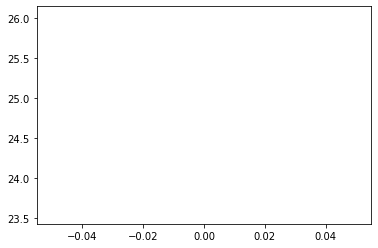

50 average loss: 26.555155810187845 lr: 0.000125


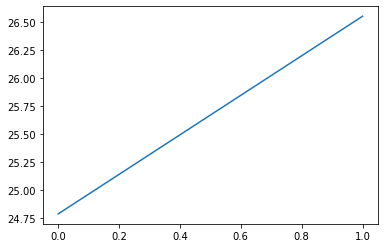

100 average loss: 26.46606934424674 lr: 0.000125


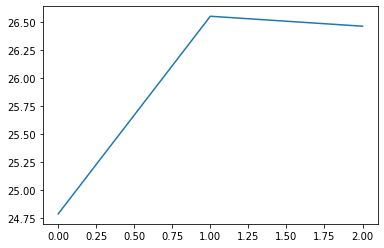

150 average loss: 26.630699915601724 lr: 0.000125


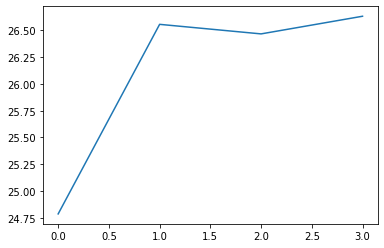

200 average loss: 26.517923516420588 lr: 0.000125


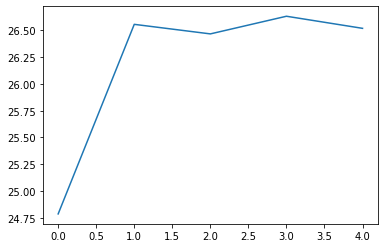

250 average loss: 26.533073045343045 lr: 0.000125


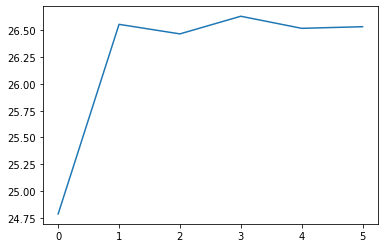

300 average loss: 26.365690218649835 lr: 0.000125


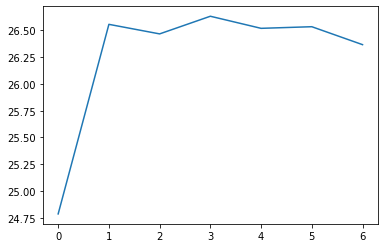

350 average loss: 26.334449920219583 lr: 0.000125


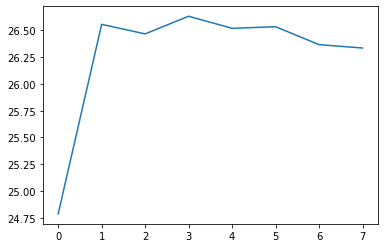

400 average loss: 26.305700573243413 lr: 0.000125


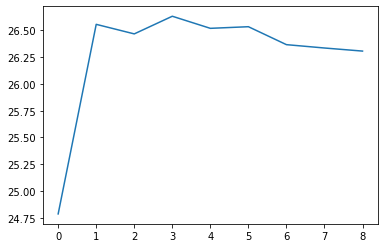

450 average loss: 26.27841175527637 lr: 0.000125


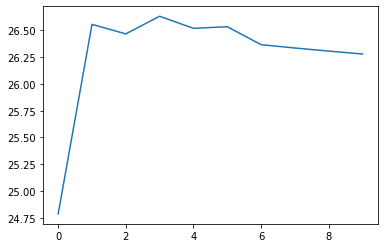

500 average loss: 26.317764095679497 lr: 0.000125


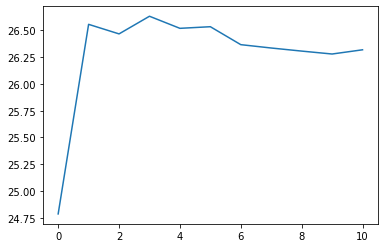

550 average loss: 26.27272247619076 lr: 0.000125


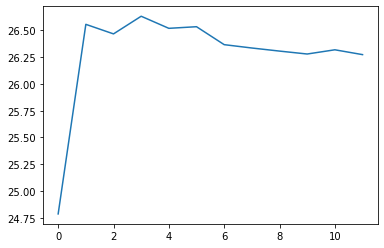

600 average loss: 26.23579070016668 lr: 0.000125


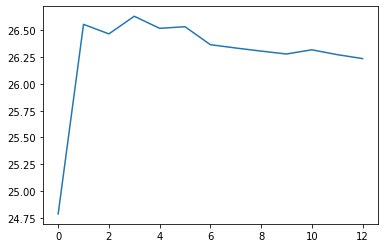

650 average loss: 26.233187814645156 lr: 0.000125


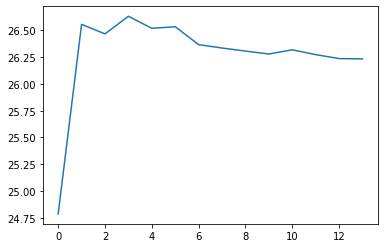

700 average loss: 26.23932894762506 lr: 0.000125


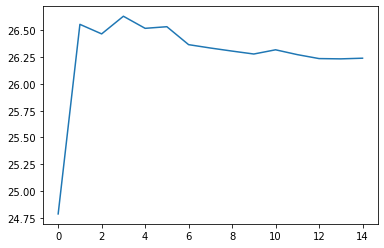

750 average loss: 26.320560066741265 lr: 0.000125


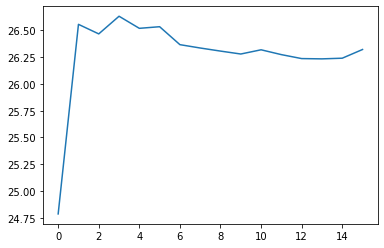

800 average loss: 26.272930483395402 lr: 0.000125


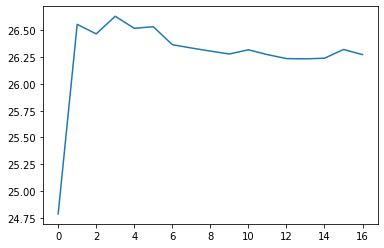

850 average loss: 26.231843421658127 lr: 0.000125


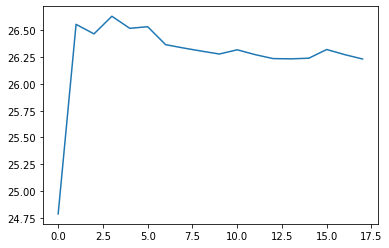

900 average loss: 26.163308375418925 lr: 0.000125


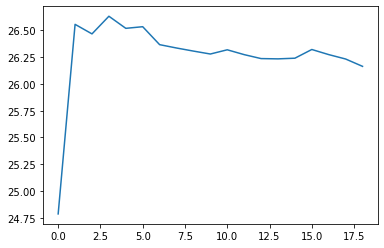

950 average loss: 26.218329015465073 lr: 0.000125


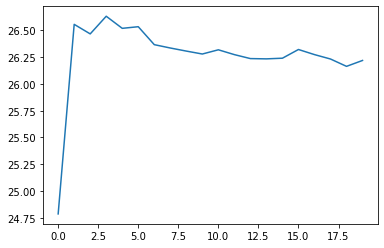

1000 average loss: 26.243925348028448 lr: 0.000125


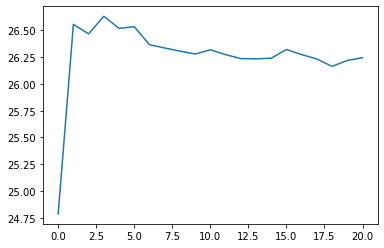

1050 average loss: 26.235757579132002 lr: 0.000125


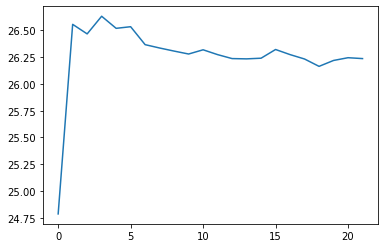

1100 average loss: 26.211968935586235 lr: 0.000125


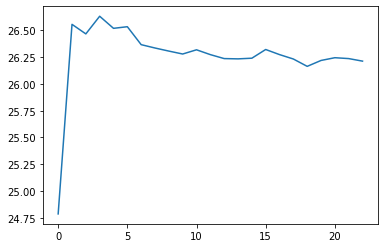

1150 average loss: 26.210992620884088 lr: 0.000125


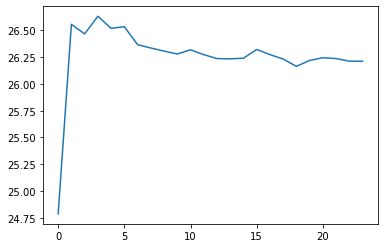

1200 average loss: 26.27112177230239 lr: 0.000125


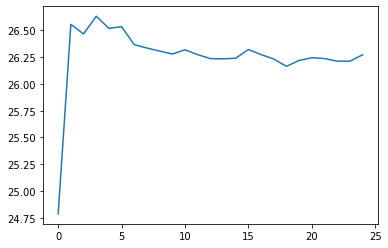

1250 average loss: 26.270189791465192 lr: 0.000125


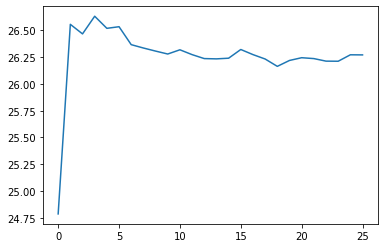

1300 average loss: 26.268891251701124 lr: 0.000125


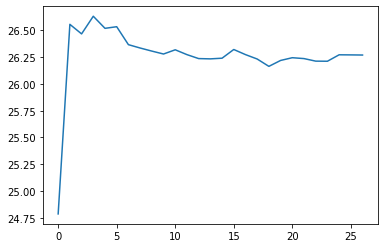

1350 average loss: 26.290778722699553 lr: 0.000125


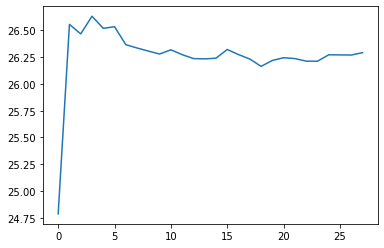

1400 average loss: 26.29642253088834 lr: 0.000125


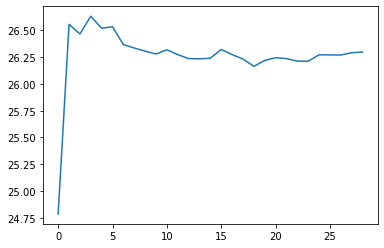

1450 average loss: 26.329073497790638 lr: 0.000125


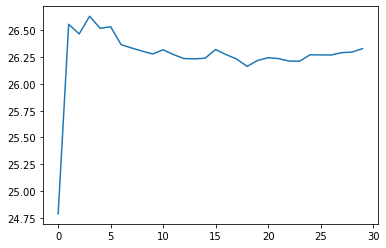

1500 average loss: 26.32842579815566 lr: 0.000125


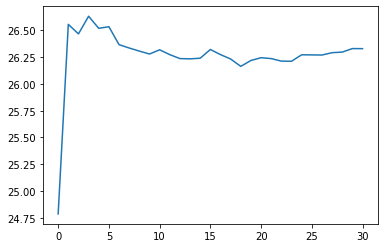

1550 average loss: 26.320389141965745 lr: 0.000125


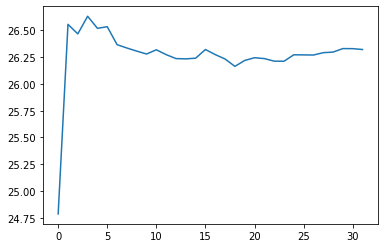

1600 average loss: 26.279919981137446 lr: 0.000125


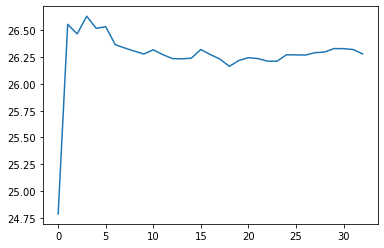

1650 average loss: 26.27304793877144 lr: 0.000125


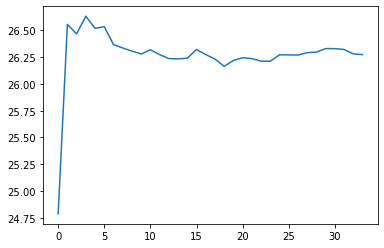

1700 average loss: 26.249556312134953 lr: 0.000125


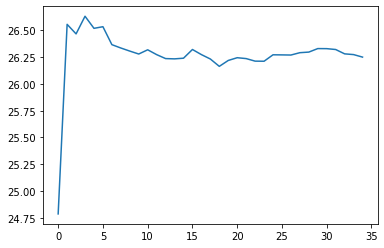

1750 average loss: 26.249833547612877 lr: 0.000125


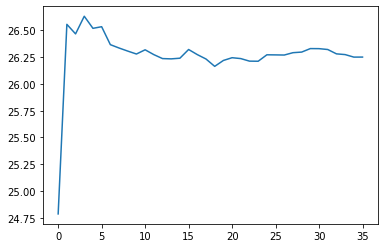

1800 average loss: 26.271174961960643 lr: 0.000125


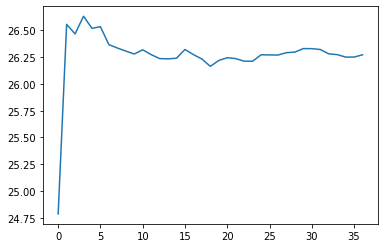

1850 average loss: 26.270286985116044 lr: 0.000125


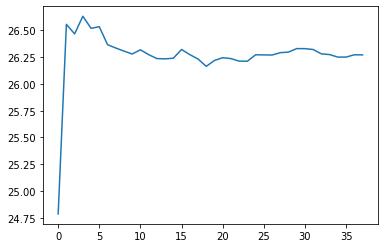

1900 average loss: 26.26114765259545 lr: 0.000125


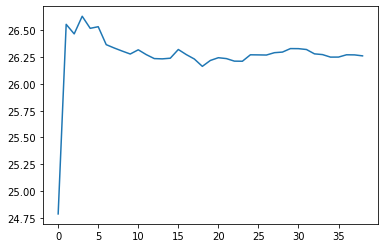

1950 average loss: 26.24081327584022 lr: 0.000125


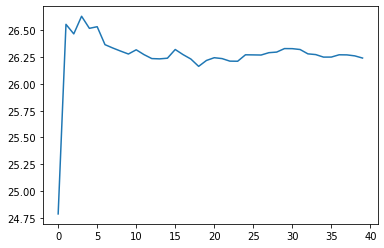

2000 average loss: 26.232746363996817 lr: 0.000125


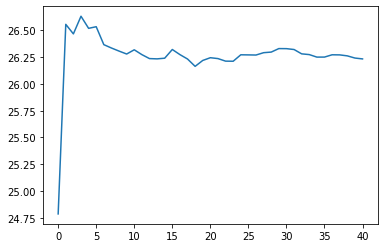

2050 average loss: 26.22220395774973 lr: 0.000125


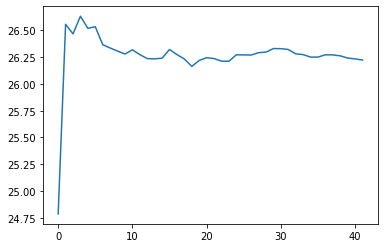

2100 average loss: 26.22055999441752 lr: 0.000125


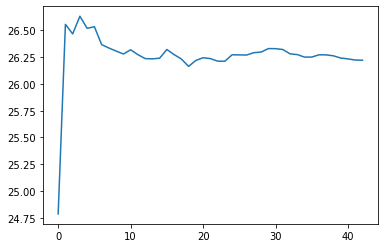

2150 average loss: 26.234151571975215 lr: 0.000125


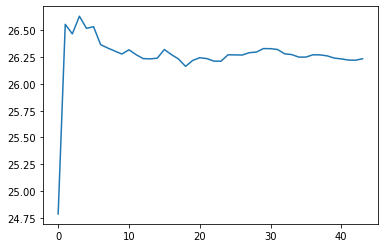

2200 average loss: 26.210014059455876 lr: 0.000125


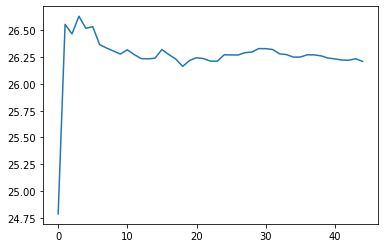

2250 average loss: 26.230122667903224 lr: 0.000125


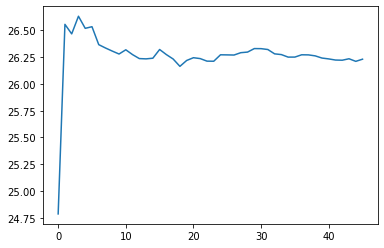

2300 average loss: 26.20544739590165 lr: 0.000125


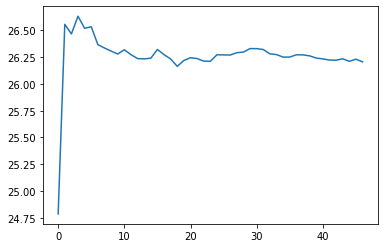

2350 average loss: 26.214655485116705 lr: 0.000125


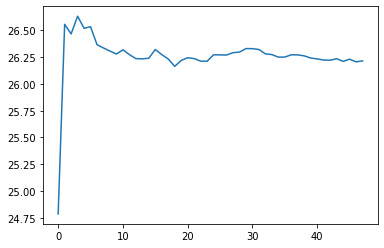

2400 average loss: 26.21091443824055 lr: 0.000125


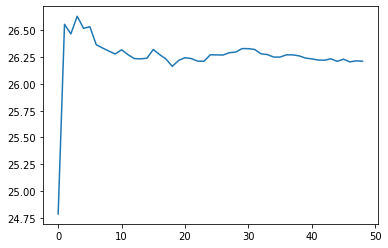

2450 average loss: 26.211117119557628 lr: 0.000125


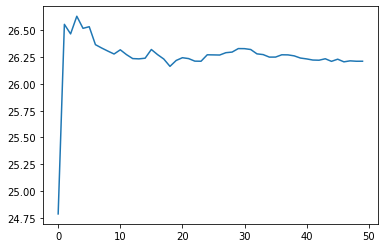

2500 average loss: 26.20707509118242 lr: 0.000125


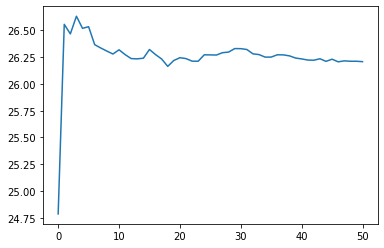

2550 average loss: 26.194894469891867 lr: 0.000125


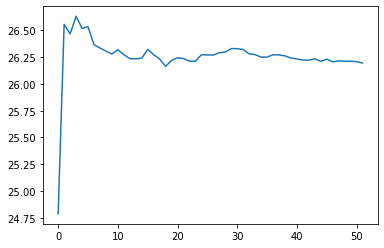

2600 average loss: 26.210072817686953 lr: 0.000125


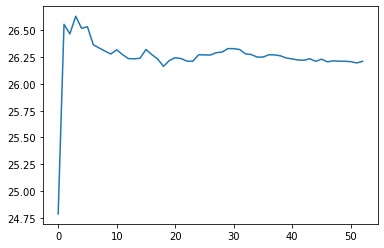

2650 average loss: 26.211083320436387 lr: 0.000125


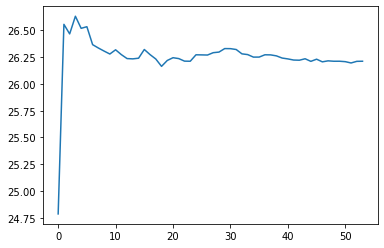

2700 average loss: 26.2264562668248 lr: 0.000125


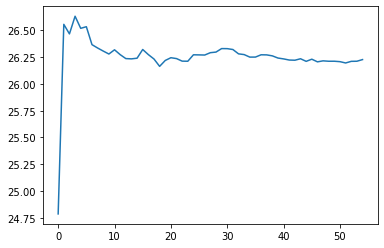

2750 average loss: 26.208236585483274 lr: 0.000125


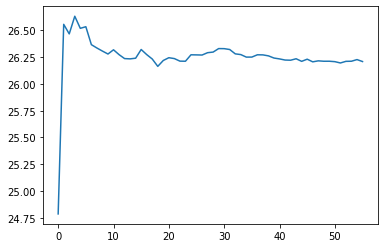

2800 average loss: 26.19415022738703 lr: 0.000125


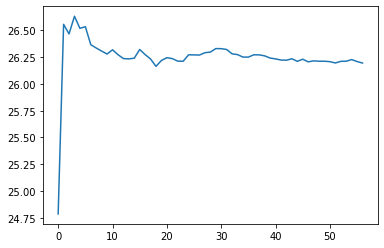

2850 average loss: 26.195278759129817 lr: 0.000125


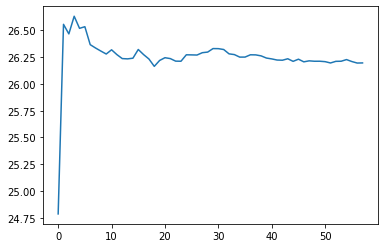

2900 average loss: 26.181482007362995 lr: 0.000125


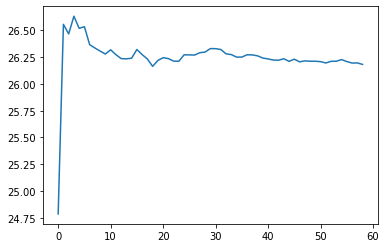

2950 average loss: 26.185659731092898 lr: 0.000125


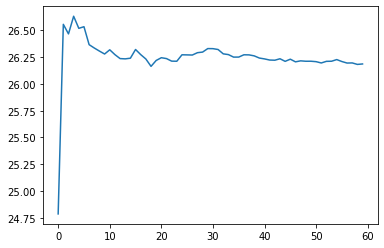

3000 average loss: 26.174519748300064 lr: 0.000125


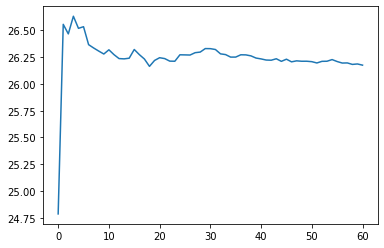

3050 average loss: 26.16446245494183 lr: 0.000125


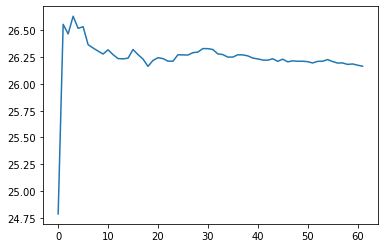

3100 average loss: 26.175507517485283 lr: 0.000125


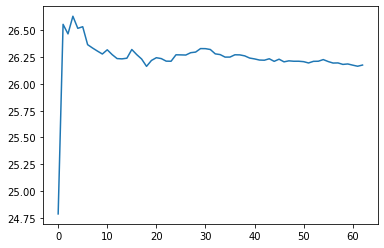

3150 average loss: 26.17381703683364 lr: 0.000125


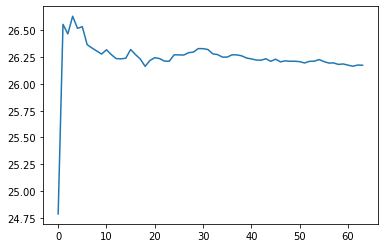

3200 average loss: 26.180085952339322 lr: 0.000125


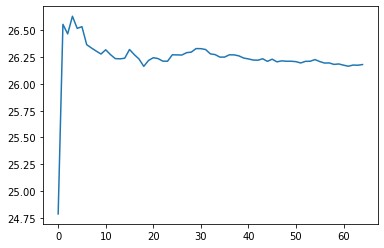

3250 average loss: 26.178536174848112 lr: 0.000125


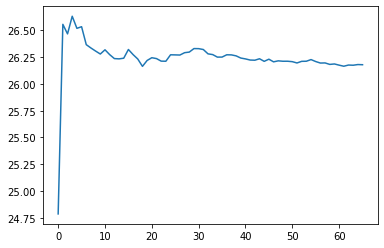

3300 average loss: 26.182927143497942 lr: 0.000125


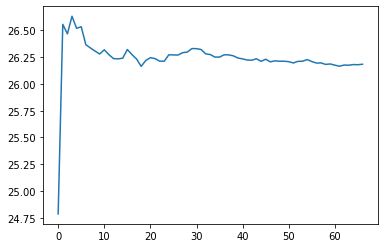

3350 average loss: 26.167714194374934 lr: 0.000125


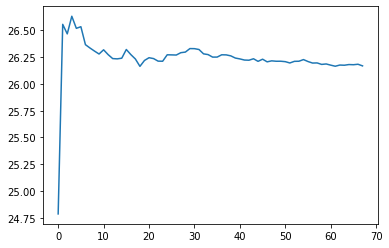

3400 average loss: 26.17769112680914 lr: 0.000125


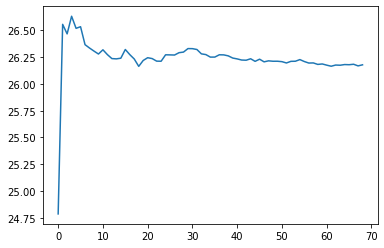

3450 average loss: 26.176608224635 lr: 0.000125


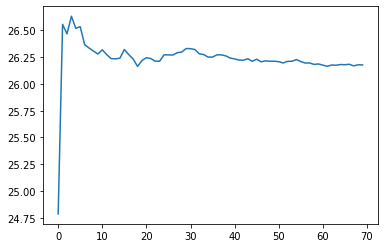

3500 average loss: 26.179893170585313 lr: 0.000125


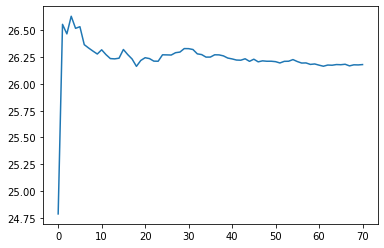

3550 average loss: 26.1760090334051 lr: 0.000125


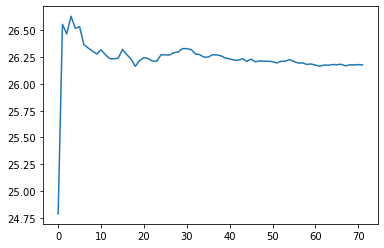

3600 average loss: 26.176600156708332 lr: 0.000125


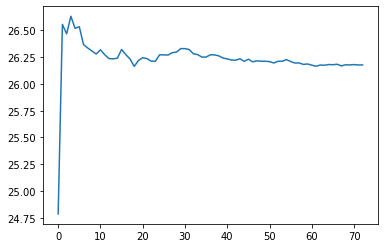

3650 average loss: 26.1729684775903 lr: 0.000125


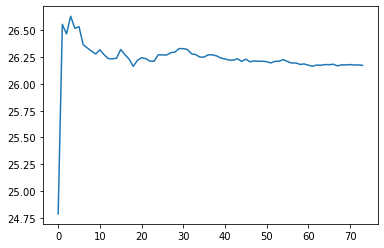

3700 average loss: 26.174403542861604 lr: 0.000125


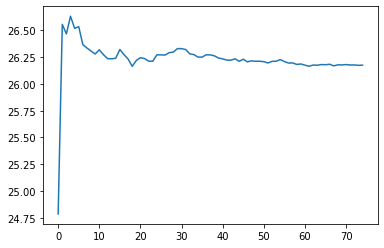

3750 average loss: 26.170305476319612 lr: 0.000125


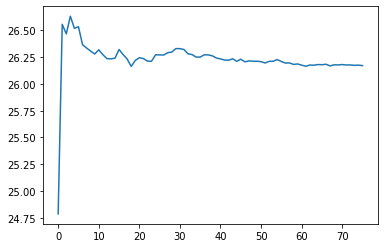

3800 average loss: 26.163350468841063 lr: 0.000125


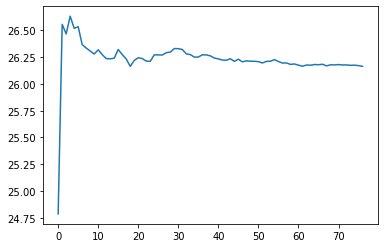

3850 average loss: 26.15752568340278 lr: 0.000125


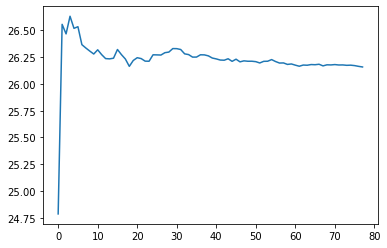

3900 average loss: 26.163441667065396 lr: 0.000125


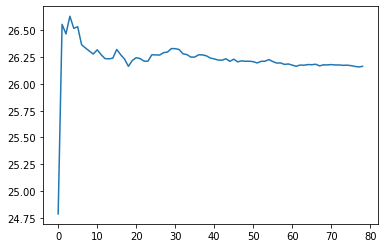

3950 average loss: 26.160361198014005 lr: 0.000125


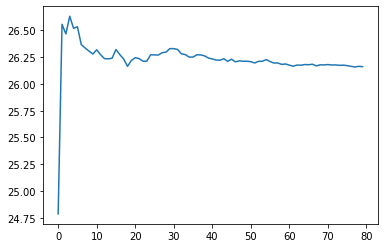

4000 average loss: 26.162867919590095 lr: 0.000125


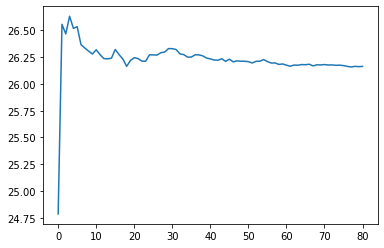

4050 average loss: 26.168872436809718 lr: 0.000125


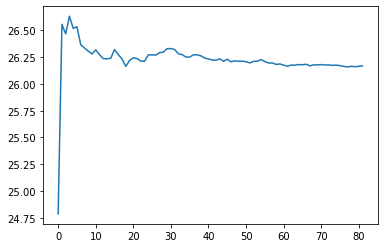

4100 average loss: 26.16009368096525 lr: 0.000125


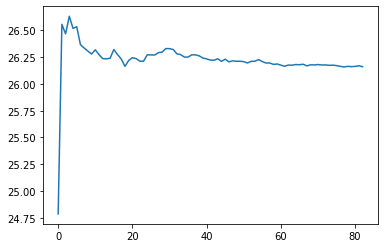

4150 average loss: 26.15256772171128 lr: 0.000125


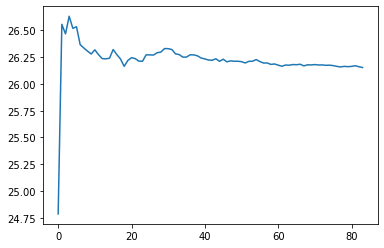

4200 average loss: 26.159256729674443 lr: 0.000125


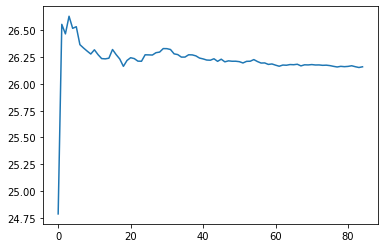

4250 average loss: 26.152093296414456 lr: 0.000125


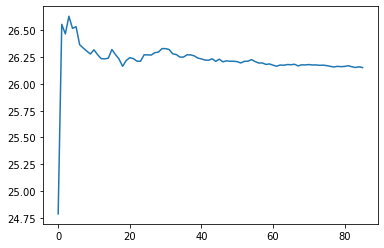

4300 average loss: 26.156958254734555 lr: 0.000125


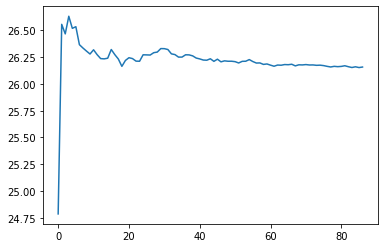

4350 average loss: 26.159885471811315 lr: 0.000125


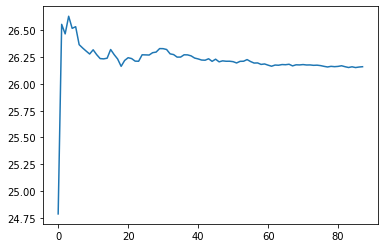

4400 average loss: 26.1662976044575 lr: 0.000125


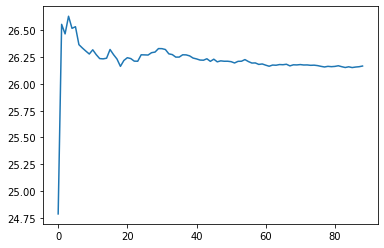

4450 average loss: 26.173462432573384 lr: 0.000125


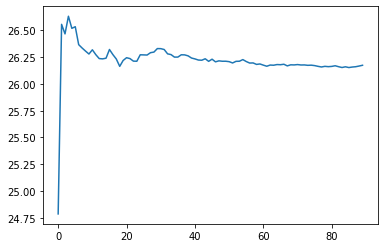

4500 average loss: 26.1849028479918 lr: 0.000125


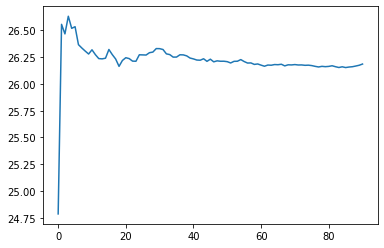

4550 average loss: 26.183205224215083 lr: 0.000125


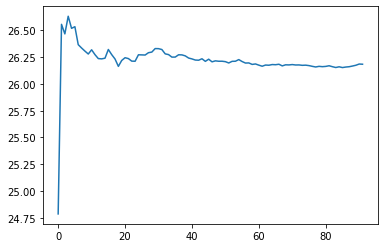

4600 average loss: 26.184289963135004 lr: 0.000125


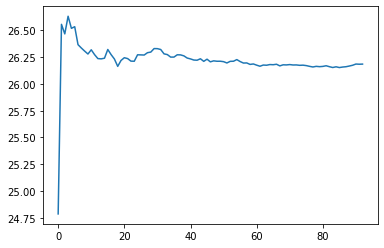

4650 average loss: 26.182213851749903 lr: 0.000125


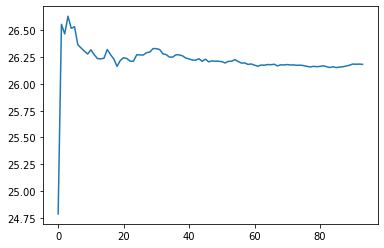

4700 average loss: 26.18043273308255 lr: 0.000125


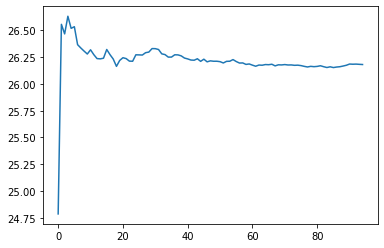

4750 average loss: 26.180562584607415 lr: 0.000125


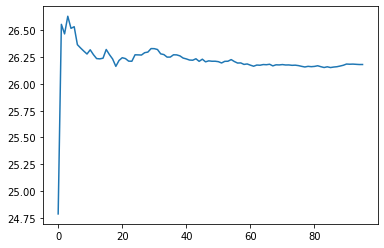

4800 average loss: 26.173197788388684 lr: 0.000125


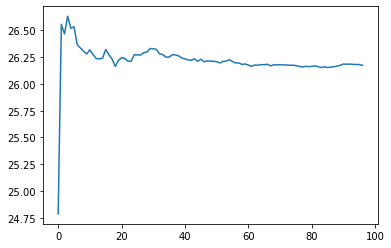

4850 average loss: 26.183441575938343 lr: 0.000125


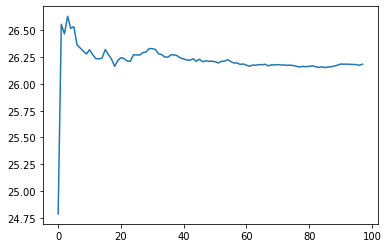

4900 average loss: 26.18145228687338 lr: 0.000125


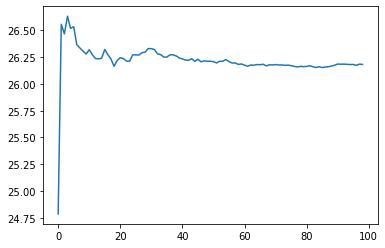

4950 average loss: 26.18269285330309 lr: 0.000125


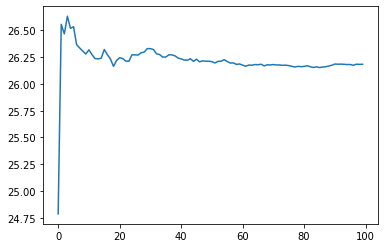

5000 average loss: 26.18582547166253 lr: 0.000125


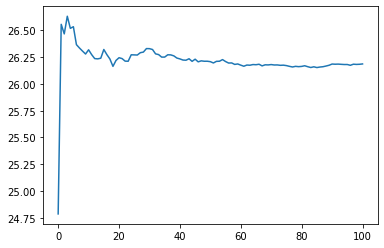

0 average loss: 31.992782592773438 lr: 0.000125


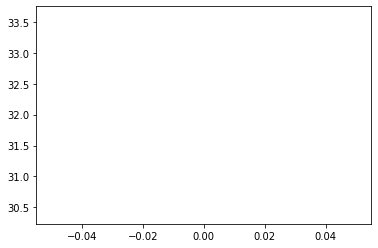

50 average loss: 27.541194915771484 lr: 0.000125


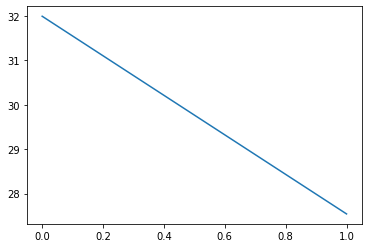

100 average loss: 27.365593088735448 lr: 0.000125


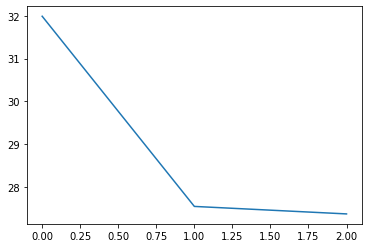

150 average loss: 27.094418658326 lr: 0.000125


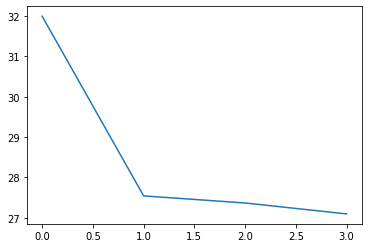

200 average loss: 27.237367819790812 lr: 0.000125


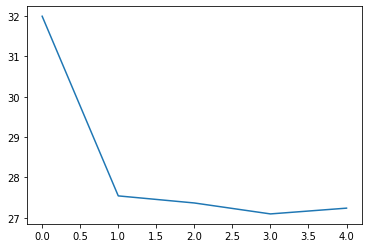

250 average loss: 27.21629429243475 lr: 0.000125


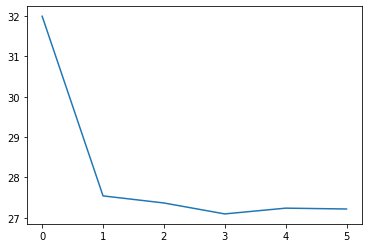

300 average loss: 27.277979451556526 lr: 0.000125


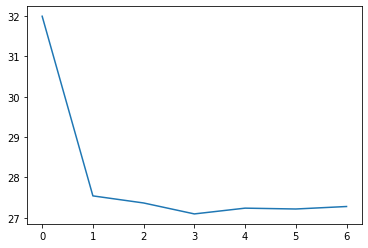

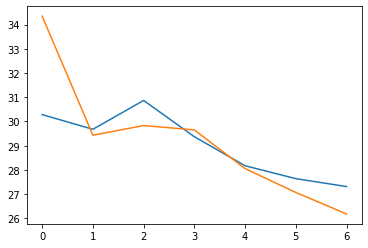

0 average loss: 23.030017852783203 lr: 0.000125


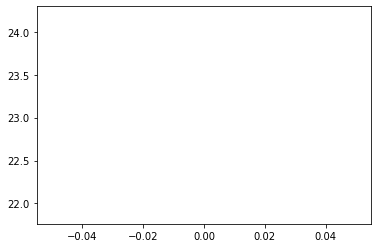

50 average loss: 26.91450085359461 lr: 0.000125


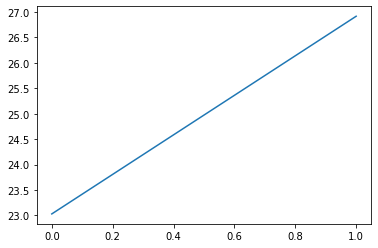

100 average loss: 26.19308626533735 lr: 0.000125


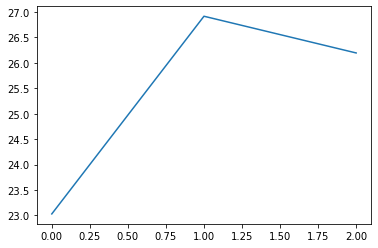

150 average loss: 25.818081925246883 lr: 0.000125


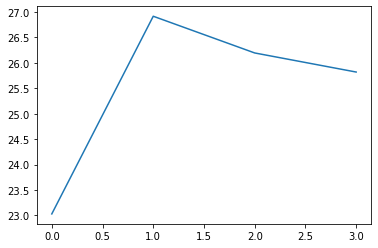

200 average loss: 25.646941948885942 lr: 0.000125


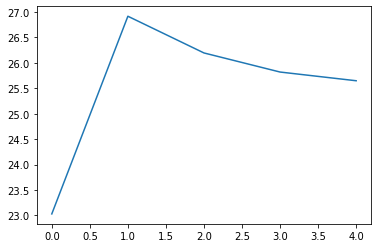

250 average loss: 25.75935479274309 lr: 0.000125


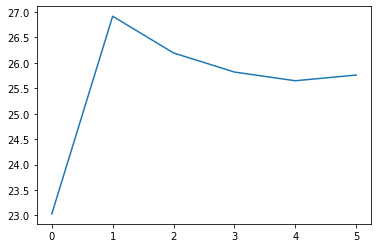

300 average loss: 25.822804523860896 lr: 0.000125


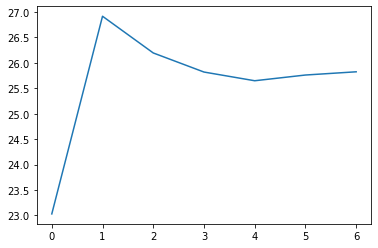

350 average loss: 25.859858950318785 lr: 0.000125


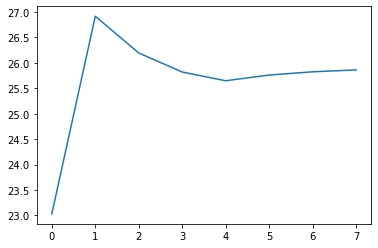

400 average loss: 25.929462547016865 lr: 0.000125


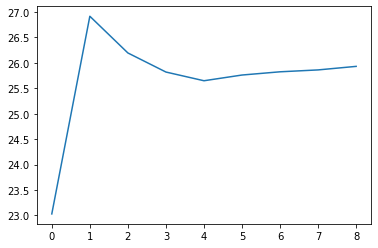

450 average loss: 25.957721997787583 lr: 0.000125


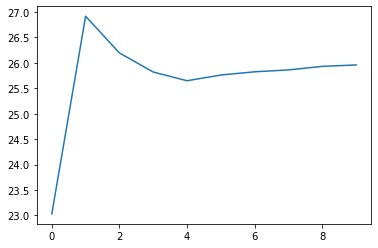

500 average loss: 25.846773376008002 lr: 0.000125


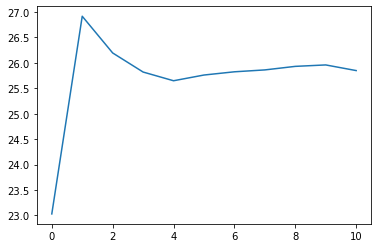

550 average loss: 25.921315869921568 lr: 0.000125


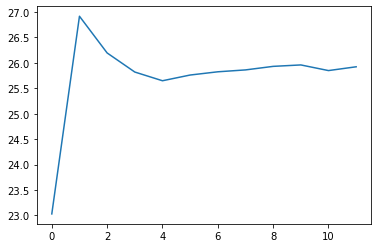

600 average loss: 25.957881860844108 lr: 0.000125


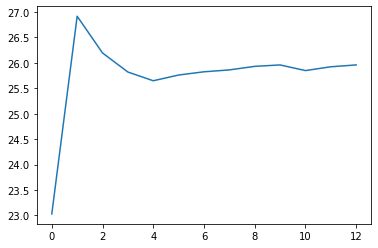

650 average loss: 25.94418127525786 lr: 0.000125


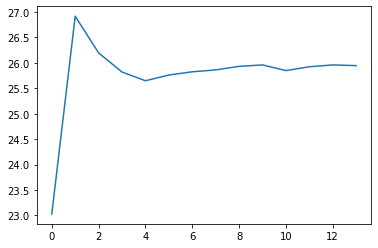

700 average loss: 25.998511408263024 lr: 0.000125


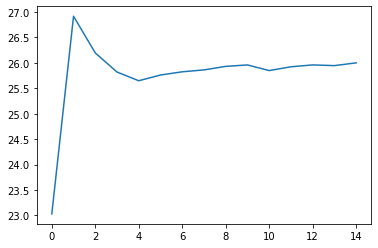

750 average loss: 25.95490714935424 lr: 0.000125


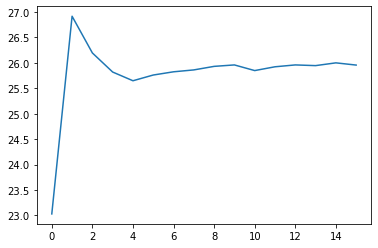

800 average loss: 25.930567230624646 lr: 0.000125


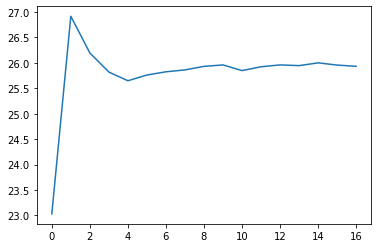

850 average loss: 25.89523556593862 lr: 0.000125


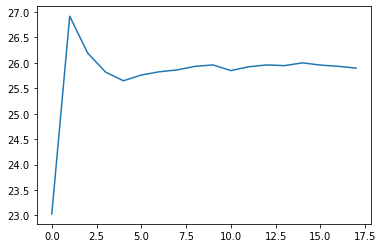

900 average loss: 25.843239649816038 lr: 0.000125


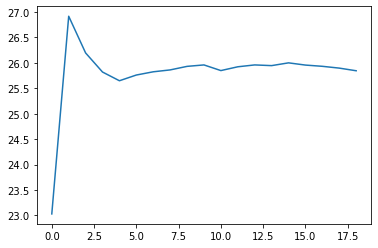

950 average loss: 25.83233081805593 lr: 0.000125


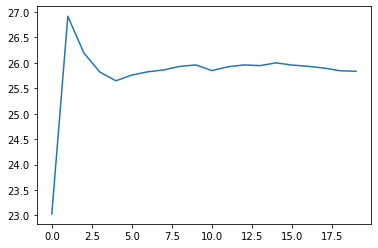

1000 average loss: 25.79041012088497 lr: 0.000125


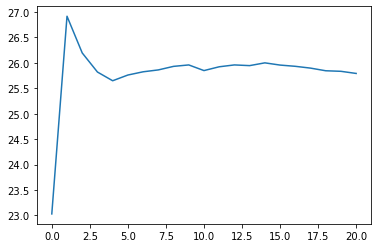

1050 average loss: 25.787886339182176 lr: 0.000125


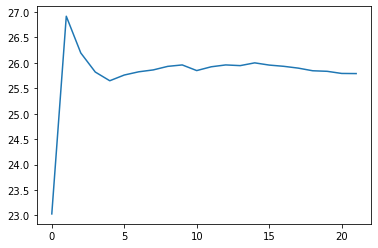

1100 average loss: 25.798539044746587 lr: 0.000125


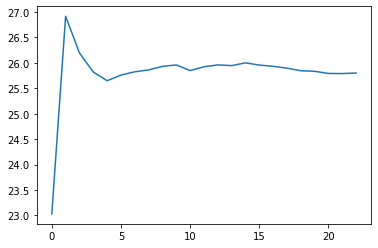

1150 average loss: 25.814825313180343 lr: 0.000125


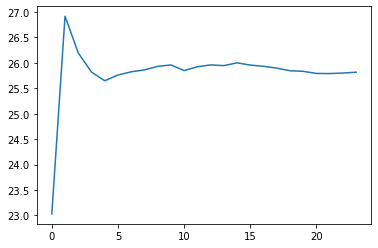

1200 average loss: 25.798294967854645 lr: 0.000125


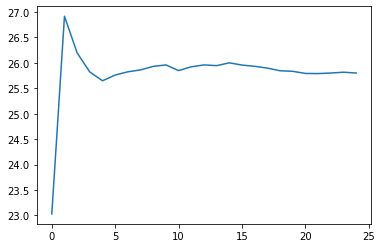

1250 average loss: 25.78586526988126 lr: 0.000125


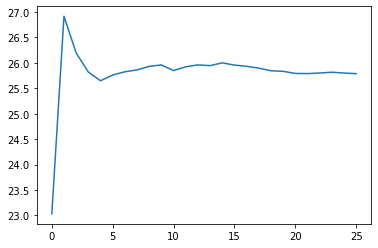

1300 average loss: 25.753857026917476 lr: 0.000125


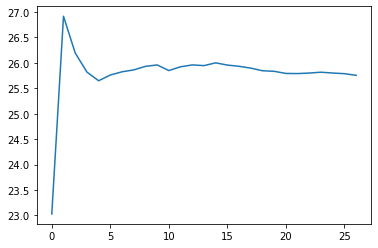

1350 average loss: 25.764743593160873 lr: 0.000125


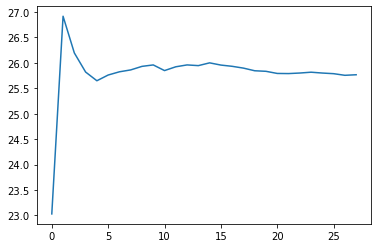

1400 average loss: 25.778430731784937 lr: 0.000125


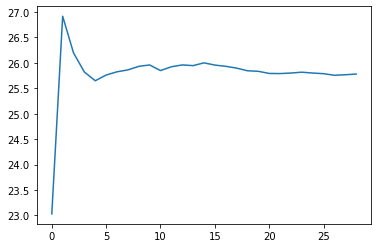

1450 average loss: 25.7611509424337 lr: 0.000125


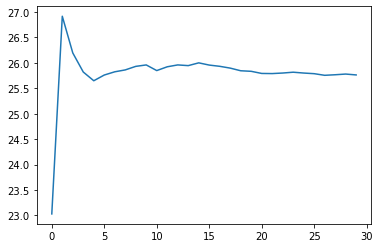

1500 average loss: 25.764446893904218 lr: 0.000125


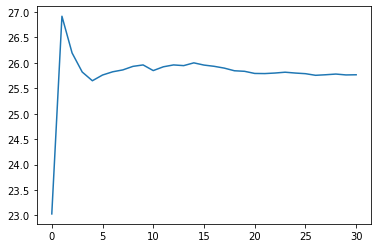

1550 average loss: 25.76982503456887 lr: 0.000125


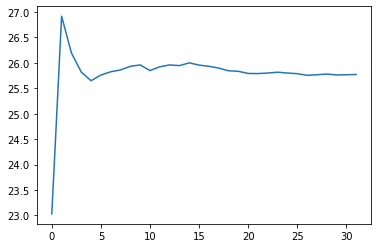

1600 average loss: 25.773653734482345 lr: 0.000125


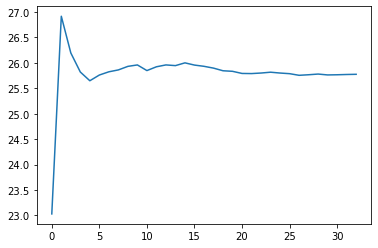

1650 average loss: 25.752741934385238 lr: 0.000125


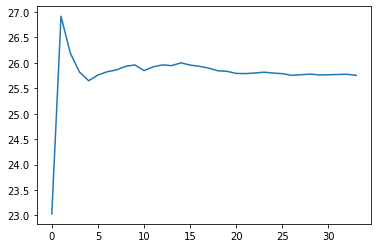

1700 average loss: 25.769989241297836 lr: 0.000125


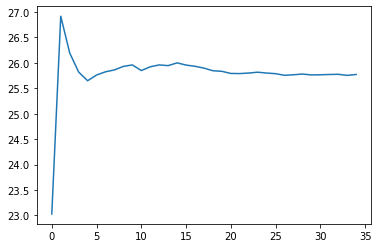

1750 average loss: 25.775429624887543 lr: 0.000125


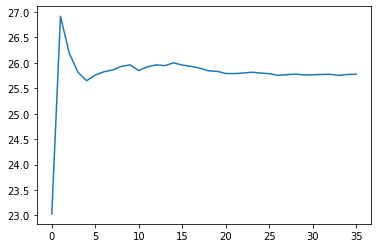

1800 average loss: 25.77403857428652 lr: 0.000125


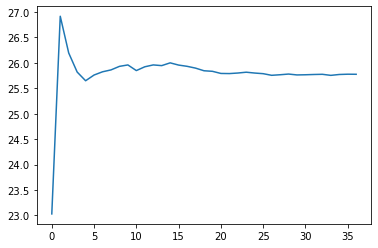

1850 average loss: 25.756816710477768 lr: 0.000125


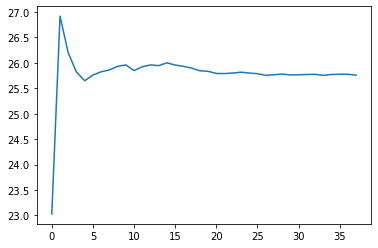

1900 average loss: 25.764308408710086 lr: 0.000125


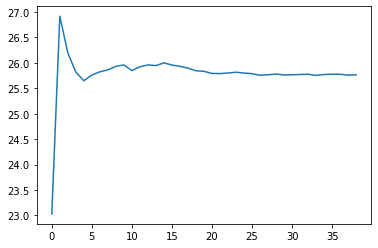

1950 average loss: 25.76225361904689 lr: 0.000125


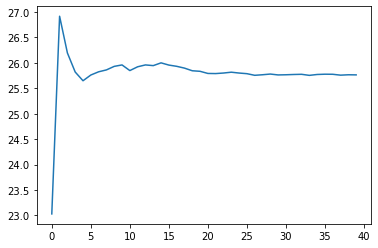

2000 average loss: 25.77372045102326 lr: 0.000125


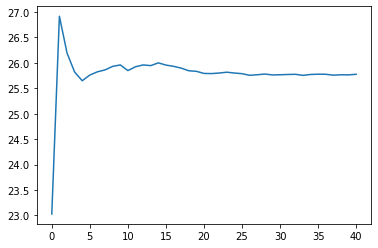

2050 average loss: 25.769042686972014 lr: 0.000125


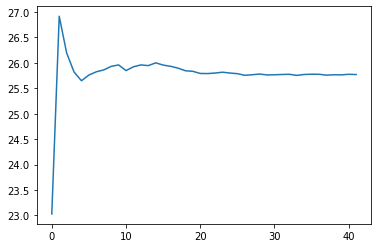

2100 average loss: 25.791081936458124 lr: 0.000125


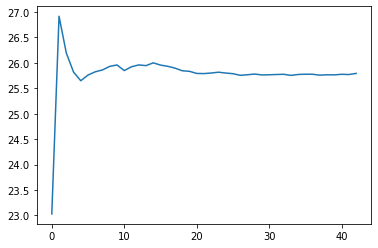

2150 average loss: 25.800023131678675 lr: 0.000125


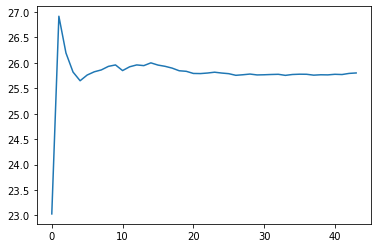

2200 average loss: 25.792964919704243 lr: 0.000125


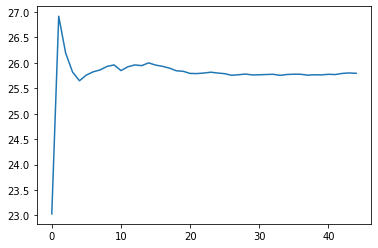

2250 average loss: 25.782863772852792 lr: 0.000125


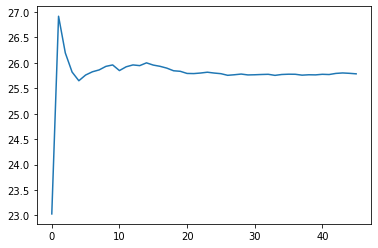

2300 average loss: 25.790088975186038 lr: 0.000125


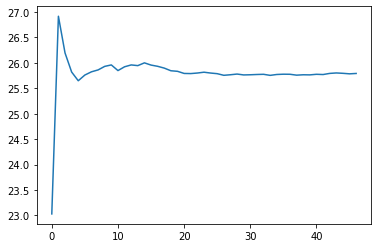

2350 average loss: 25.78914449084115 lr: 0.000125


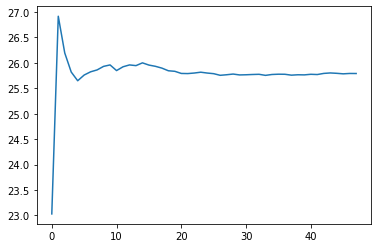

2400 average loss: 25.796104391432472 lr: 0.000125


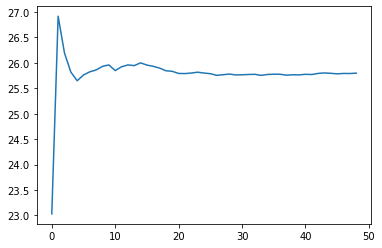

2450 average loss: 25.798253627078285 lr: 0.000125


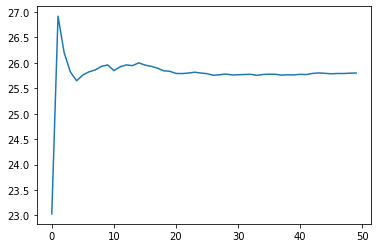

2500 average loss: 25.7957863233796 lr: 0.000125


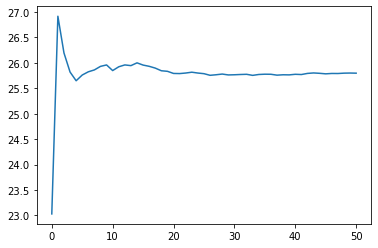

2550 average loss: 25.783111715821484 lr: 0.000125


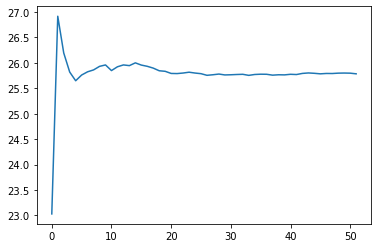

2600 average loss: 25.777596658122235 lr: 0.000125


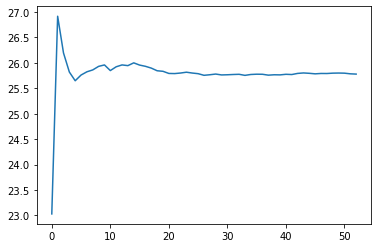

2650 average loss: 25.771671454171713 lr: 0.000125


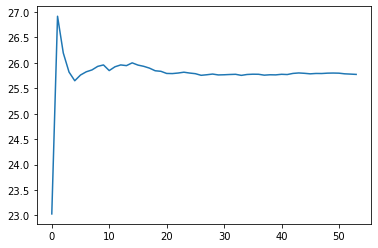

2700 average loss: 25.76065886934262 lr: 0.000125


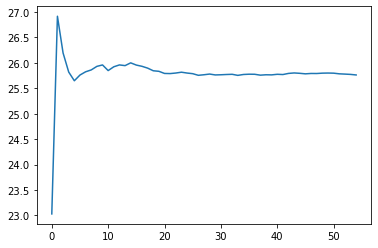

2750 average loss: 25.769903770926582 lr: 0.000125


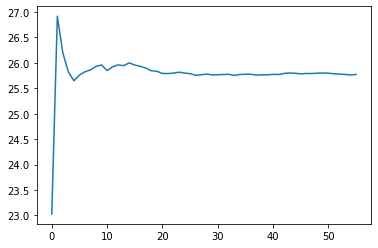

2800 average loss: 25.780249228268104 lr: 0.000125


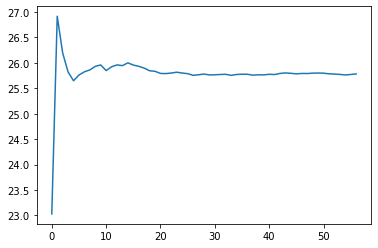

2850 average loss: 25.789467552342966 lr: 0.000125


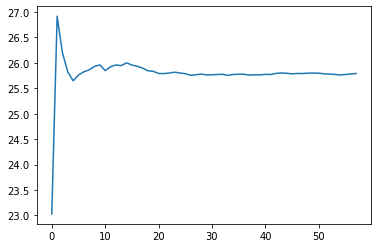

2900 average loss: 25.77185123815739 lr: 0.000125


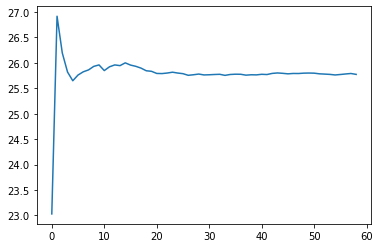

2950 average loss: 25.768260204763767 lr: 0.000125


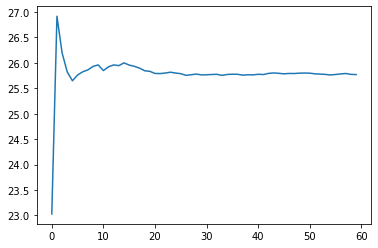

3000 average loss: 25.775308992893706 lr: 0.000125


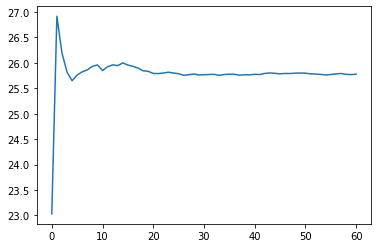

3050 average loss: 25.771140162025052 lr: 0.000125


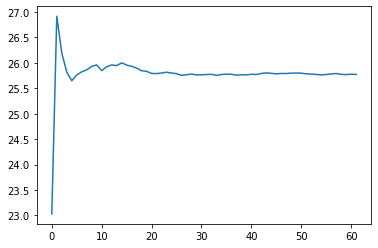

3100 average loss: 25.769965980945596 lr: 0.000125


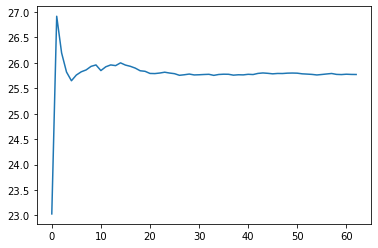

3150 average loss: 25.7743258190246 lr: 0.000125


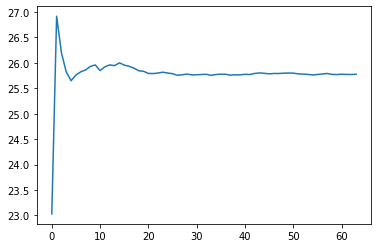

3200 average loss: 25.79119797670556 lr: 0.000125


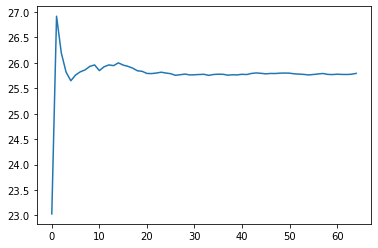

3250 average loss: 25.7818454659121 lr: 0.000125


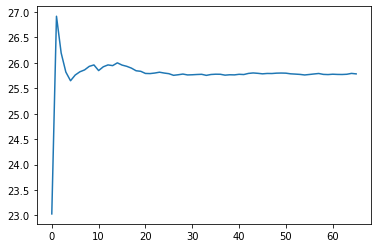

3300 average loss: 25.790406070814406 lr: 0.000125


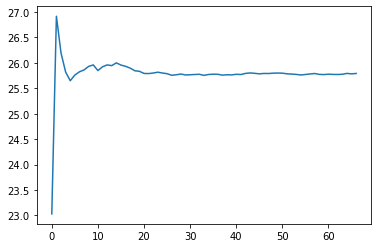

3350 average loss: 25.784272975119094 lr: 0.000125


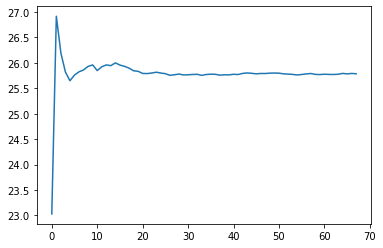

3400 average loss: 25.77922620663957 lr: 0.000125


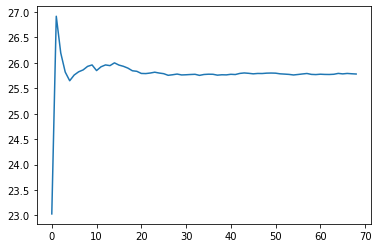

3450 average loss: 25.78649815791797 lr: 0.000125


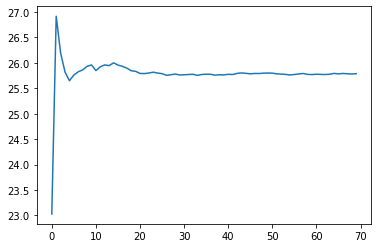

3500 average loss: 25.771901117873462 lr: 0.000125


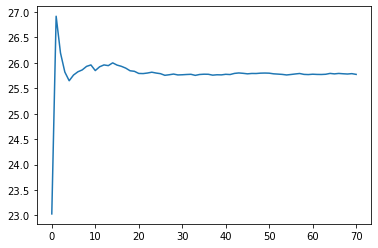

3550 average loss: 25.769177563859873 lr: 0.000125


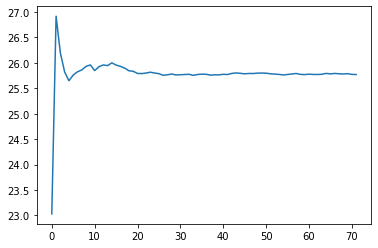

3600 average loss: 25.76766488102536 lr: 0.000125


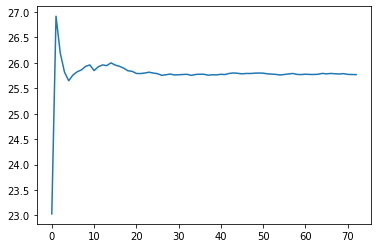

3650 average loss: 25.773512226690904 lr: 0.000125


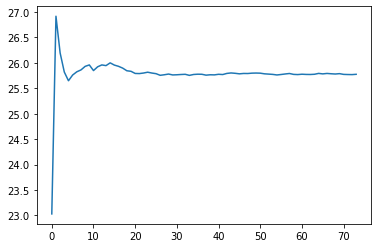

3700 average loss: 25.763850690609264 lr: 0.000125


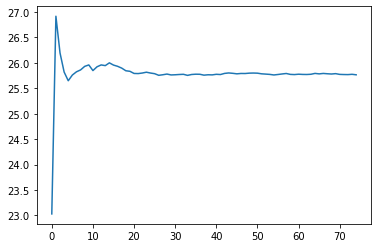

3750 average loss: 25.763338940711204 lr: 0.000125


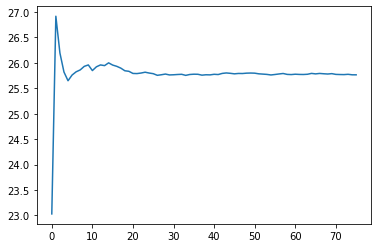

3800 average loss: 25.766469160590304 lr: 0.000125


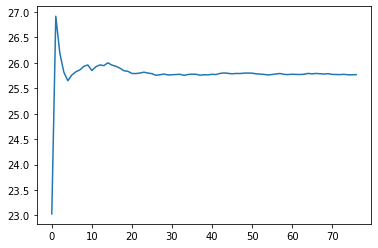

3850 average loss: 25.768227816185263 lr: 0.000125


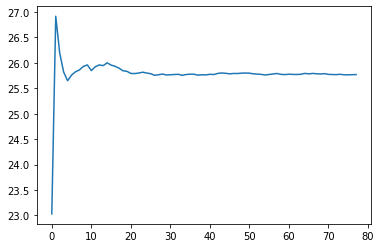

3900 average loss: 25.773304077516134 lr: 0.000125


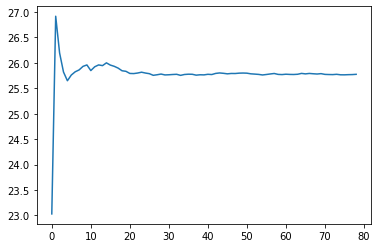

3950 average loss: 25.758306972529745 lr: 0.000125


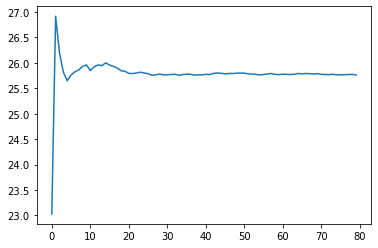

4000 average loss: 25.76434924119237 lr: 0.000125


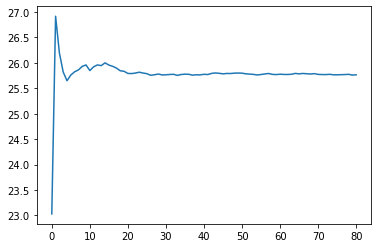

4050 average loss: 25.762121683637247 lr: 0.000125


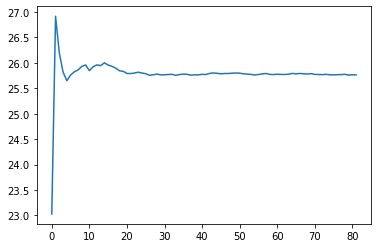

4100 average loss: 25.773454450334302 lr: 0.000125


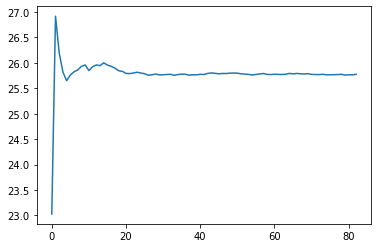

4150 average loss: 25.765291231909433 lr: 0.000125


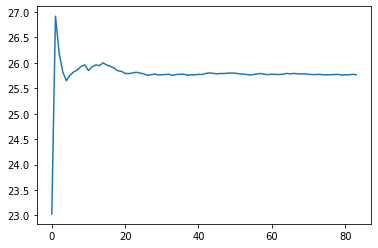

4200 average loss: 25.765653214321866 lr: 0.000125


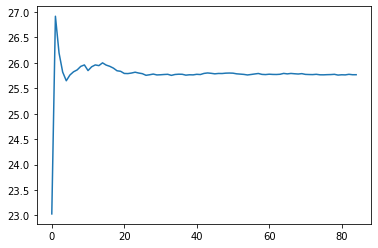

4250 average loss: 25.76558878595088 lr: 0.000125


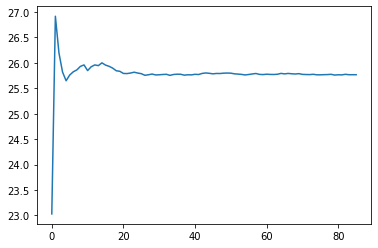

4300 average loss: 25.771921268260023 lr: 0.000125


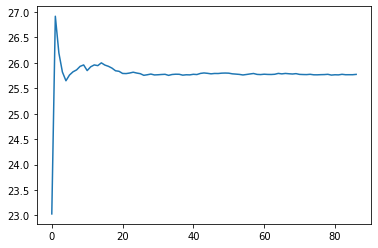

4350 average loss: 25.770625848053395 lr: 0.000125


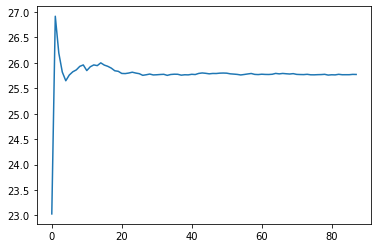

4400 average loss: 25.771893395534608 lr: 0.000125


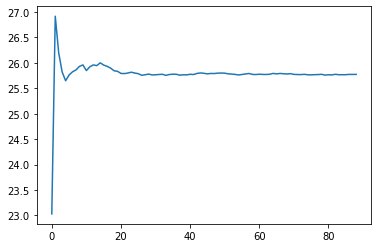

4450 average loss: 25.768995992308696 lr: 0.000125


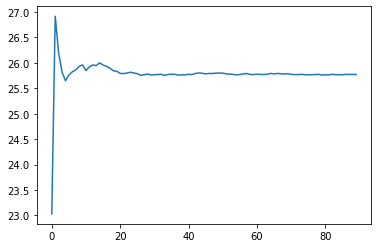

4500 average loss: 25.76412383632324 lr: 0.000125


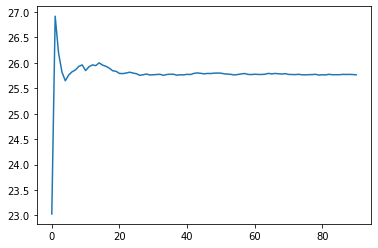

4550 average loss: 25.76181575299041 lr: 0.000125


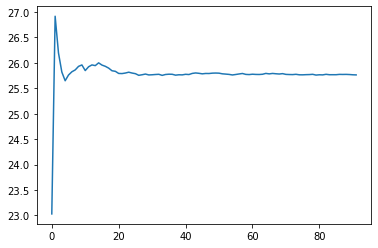

4600 average loss: 25.764375792977805 lr: 0.000125


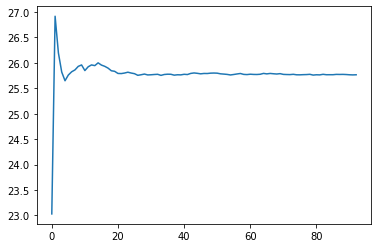

4650 average loss: 25.77271880869762 lr: 0.000125


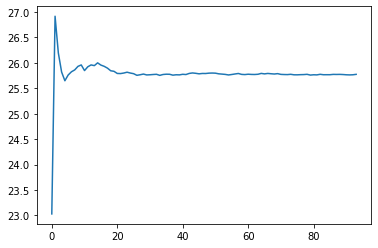

4700 average loss: 25.767321103787168 lr: 0.000125


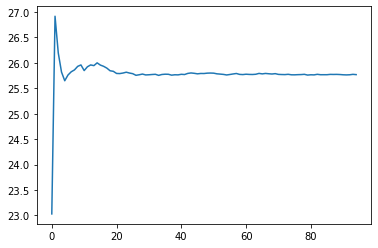

4750 average loss: 25.754765507347372 lr: 0.000125


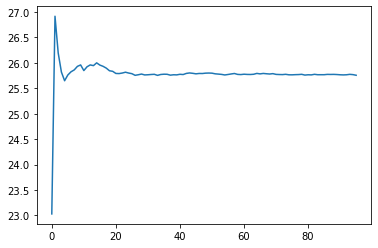

4800 average loss: 25.768190222018898 lr: 0.000125


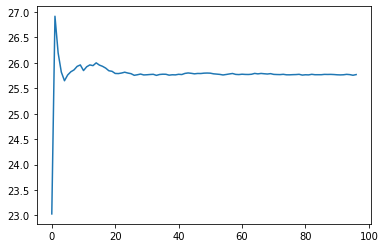

4850 average loss: 25.77297838946712 lr: 0.000125


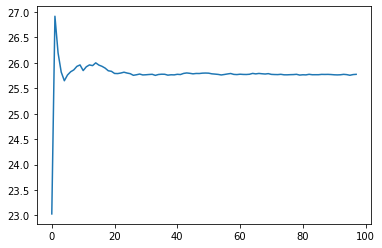

4900 average loss: 25.774637548224444 lr: 0.000125


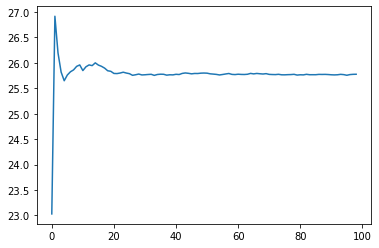

4950 average loss: 25.78272967010141 lr: 0.000125


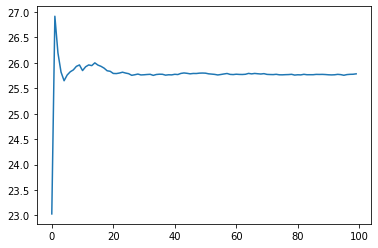

5000 average loss: 25.773947548708943 lr: 0.000125


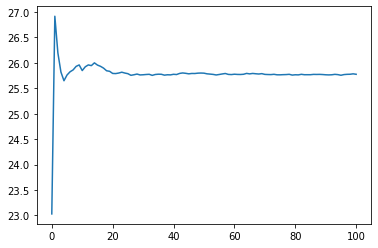

0 average loss: 31.676353454589844 lr: 0.000125


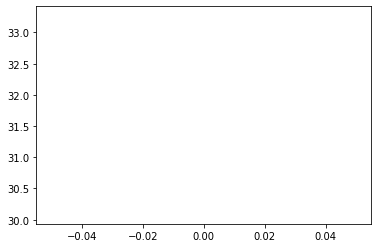

50 average loss: 27.35808926002652 lr: 0.000125


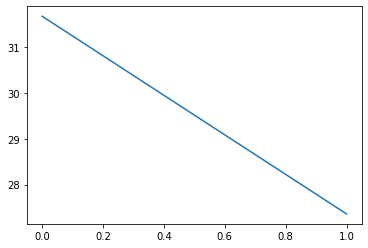

100 average loss: 27.185394173801534 lr: 0.000125


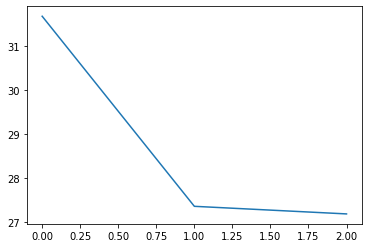

150 average loss: 26.913790469138036 lr: 0.000125


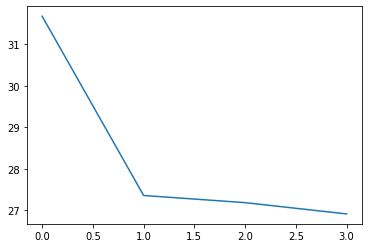

200 average loss: 27.071980063594985 lr: 0.000125


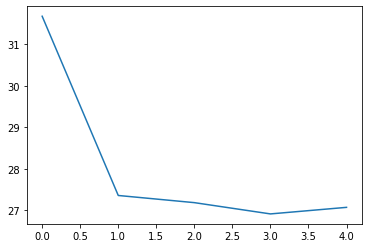

250 average loss: 27.049690748115932 lr: 0.000125


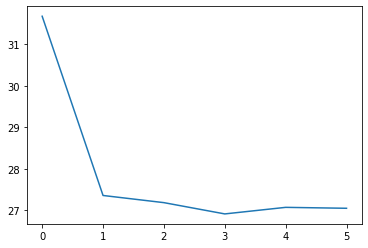

300 average loss: 27.102893411123073 lr: 0.000125


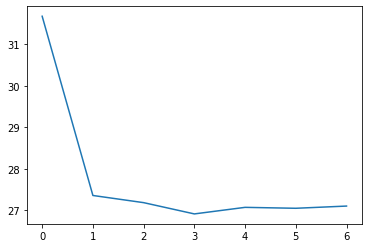

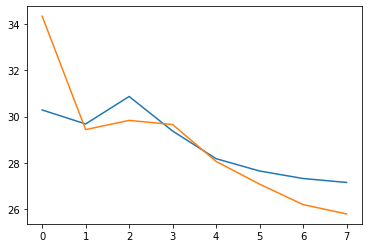

0 average loss: 18.885156631469727 lr: 0.000125


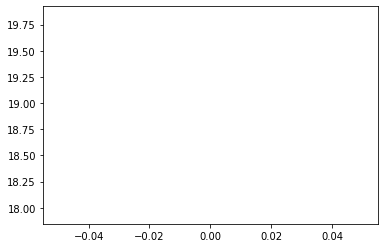

50 average loss: 26.148096084594727 lr: 0.000125


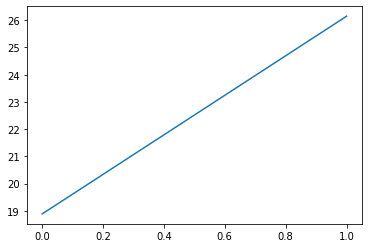

100 average loss: 25.741015330399616 lr: 0.000125


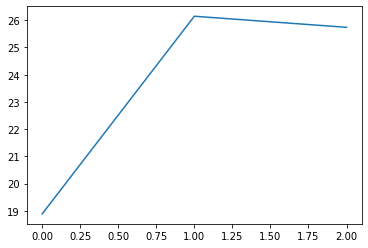

150 average loss: 25.79358343414913 lr: 0.000125


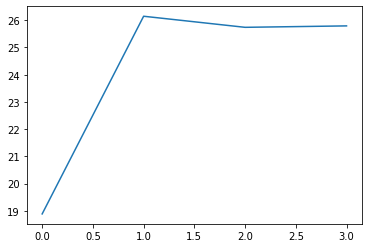

200 average loss: 25.581970490033353 lr: 0.000125


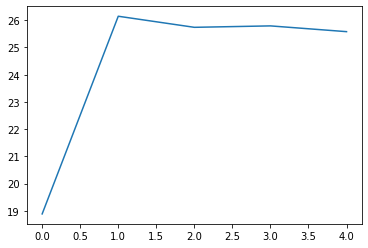

250 average loss: 25.48948231731278 lr: 0.000125


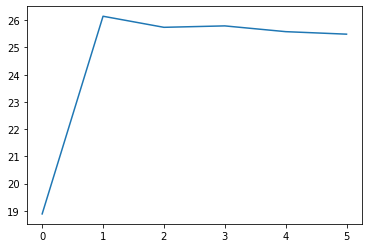

300 average loss: 25.314090614699055 lr: 0.000125


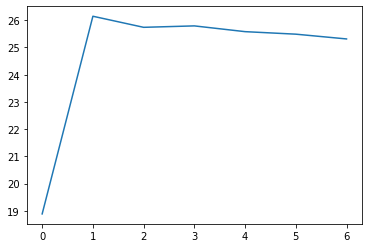

350 average loss: 25.264997895286974 lr: 0.000125


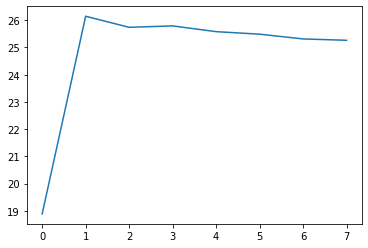

400 average loss: 25.173179502796355 lr: 0.000125


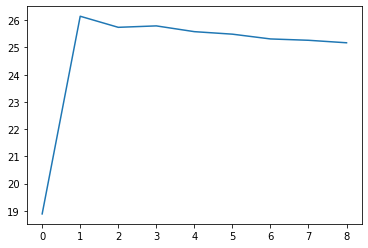

450 average loss: 25.223212053929092 lr: 0.000125


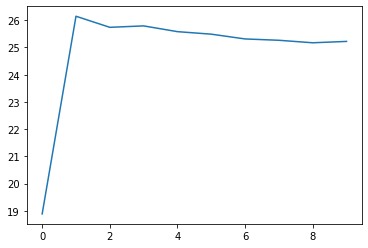

500 average loss: 25.27040141594862 lr: 0.000125


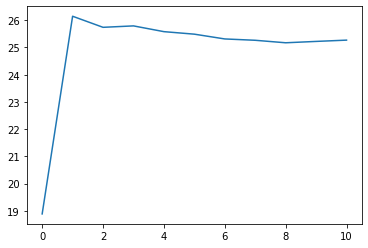

550 average loss: 25.31095400220037 lr: 0.000125


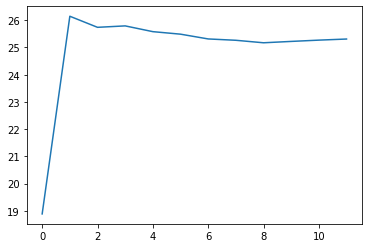

600 average loss: 25.34516730284731 lr: 0.000125


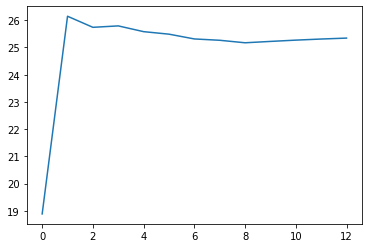

650 average loss: 25.31719535030713 lr: 0.000125


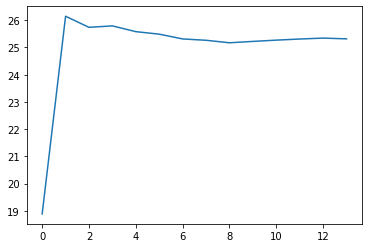

700 average loss: 25.31668097078377 lr: 0.000125


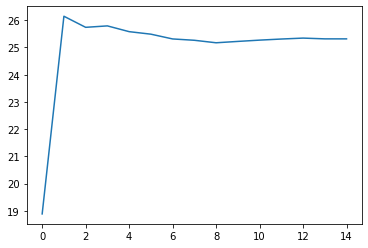

750 average loss: 25.336812599679938 lr: 0.000125


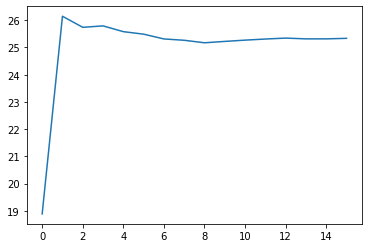

800 average loss: 25.31109245052649 lr: 0.000125


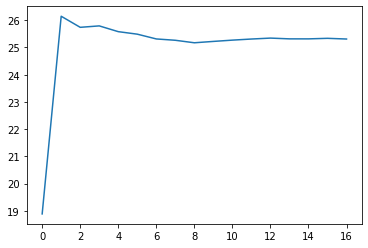

850 average loss: 25.311889933082966 lr: 0.000125


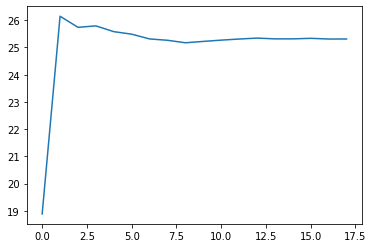

900 average loss: 25.312186066503678 lr: 0.000125


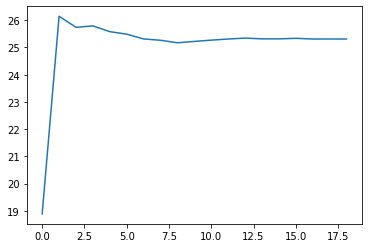

950 average loss: 25.309817666135014 lr: 0.000125


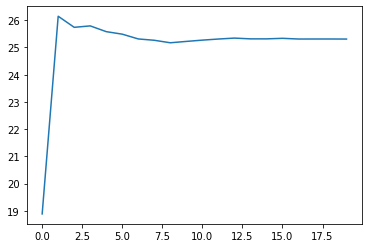

1000 average loss: 25.281747903738122 lr: 0.000125


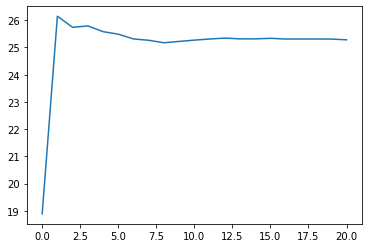

1050 average loss: 25.258854102906913 lr: 0.000125


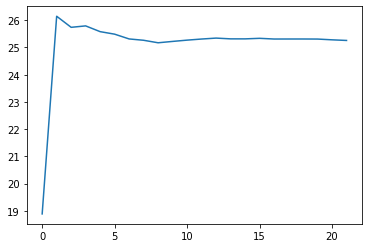

1100 average loss: 25.276032400174547 lr: 0.000125


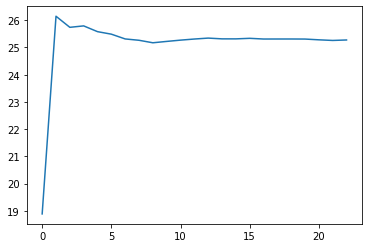

1150 average loss: 25.293185564665883 lr: 0.000125


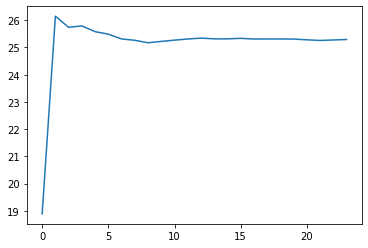

1200 average loss: 25.28101518966078 lr: 0.000125


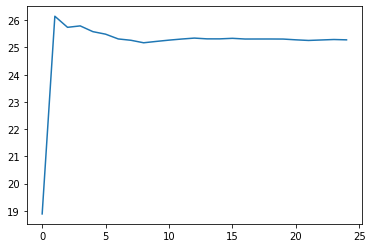

1250 average loss: 25.31973257606074 lr: 0.000125


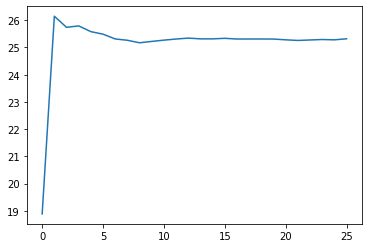

1300 average loss: 25.333759065960855 lr: 0.000125


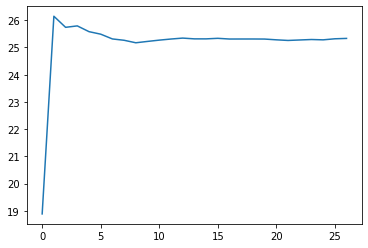

1350 average loss: 25.347025982103556 lr: 0.000125


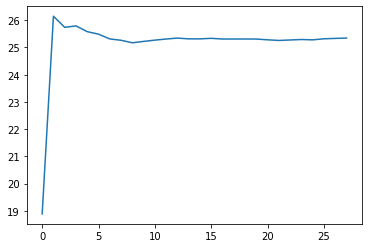

1400 average loss: 25.342708399770608 lr: 0.000125


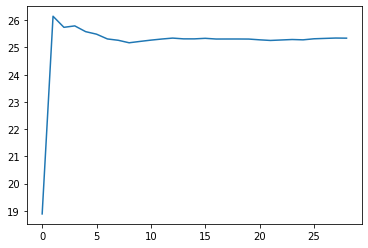

1450 average loss: 25.34051390371185 lr: 0.000125


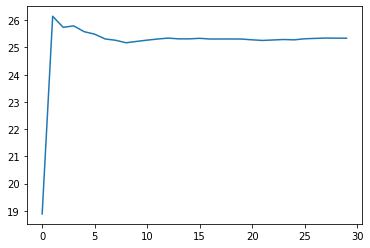

1500 average loss: 25.3316243963985 lr: 0.000125


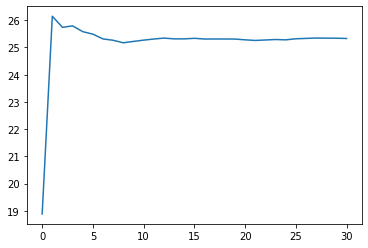

1550 average loss: 25.3342896245665 lr: 0.000125


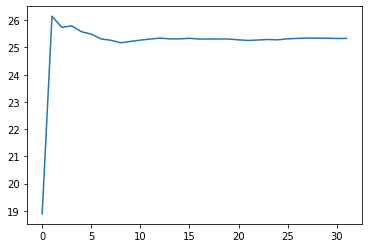

1600 average loss: 25.349143569727087 lr: 0.000125


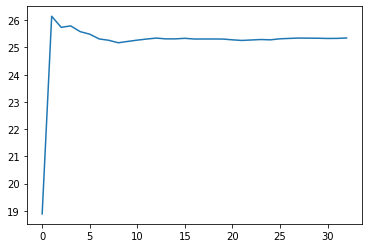

1650 average loss: 25.34369485902469 lr: 0.000125


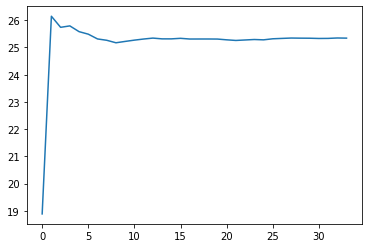

1700 average loss: 25.353619763319948 lr: 0.000125


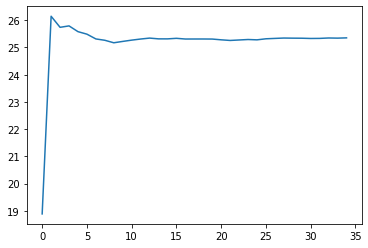

1750 average loss: 25.344811349647653 lr: 0.000125


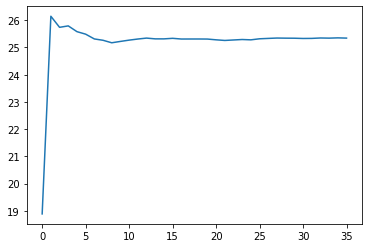

1800 average loss: 25.314708369761824 lr: 0.000125


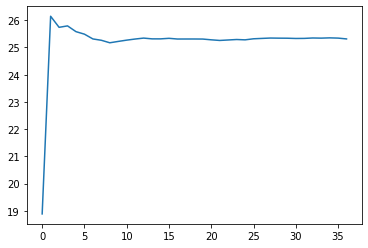

1850 average loss: 25.35518307430818 lr: 0.000125


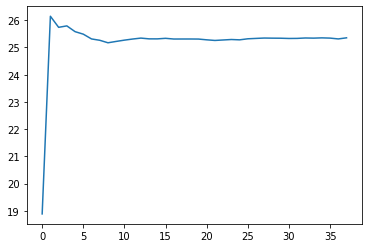

1900 average loss: 25.334043071371582 lr: 0.000125


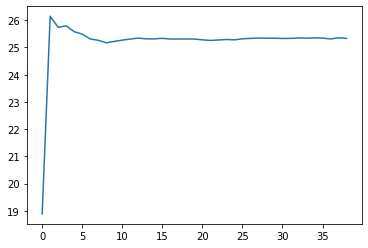

1950 average loss: 25.346667373320926 lr: 0.000125


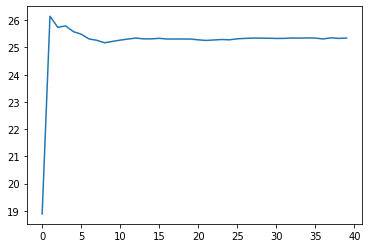

2000 average loss: 25.341441414226363 lr: 0.000125


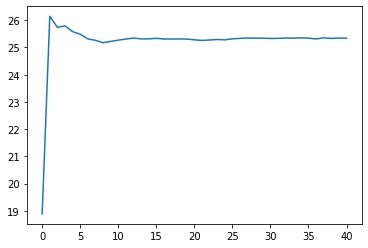

2050 average loss: 25.34577560610797 lr: 0.000125


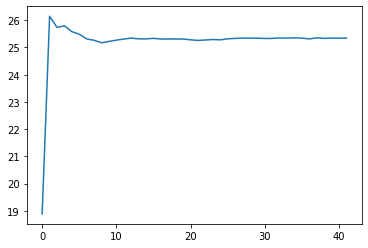

2100 average loss: 25.37193775676308 lr: 0.000125


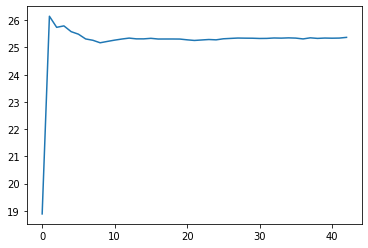

2150 average loss: 25.364330787428152 lr: 0.000125


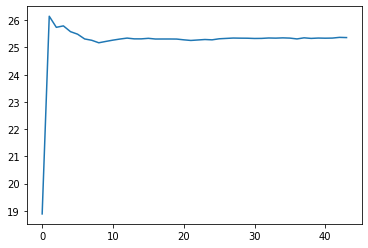

2200 average loss: 25.37544728668643 lr: 0.000125


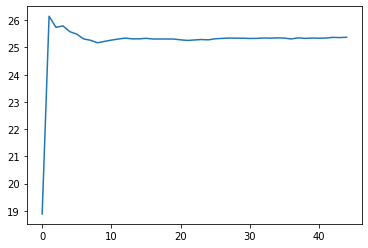

2250 average loss: 25.370491208314164 lr: 0.000125


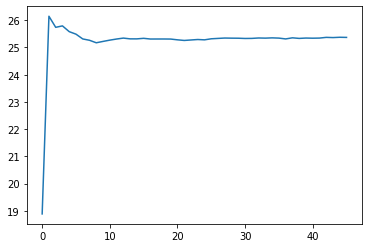

2300 average loss: 25.356620490991357 lr: 0.000125


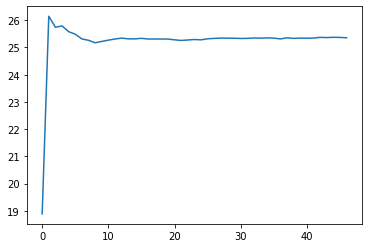

2350 average loss: 25.368546030360143 lr: 0.000125


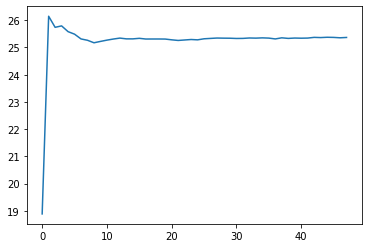

In [ ]:

for epoch in tqdm (range (3)):
    train_one_epoch(train_dataloader, model, optimizer, train_loss_tracker)
    valid_one_epoch(valid_dataloader, model, valid_loss_tracker)
    # scheduler.step()
    plt.plot (valid_loss_tracker)
    plt.plot (train_loss_tracker)
    plt.show()
    torch.save(model.state_dict(), model_path)

In [ ]:
model.load_state_dict (torch.load(model_path))
model.to(DEVICE)

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

decoded_sents = evalute (valid_dataloader, model)

def eval_bleu(target_df, predicated_sentences, ngram):
  list_of_references = []
  list_of_hypotheses = []
  for i in range(len(target_df)):
    image_fname = target_df.loc[i, 'image_fname']
    box = target_df.loc[i, 'box']
    similar_rows = target_df[ (target_df['image_fname'] == image_fname) & (target_df['box'] == box) ]
    refrences = [ sentence.split() for sentence in similar_rows['sentence'] ]
    hypotheses = predicated_sentences[i].split()
    list_of_references.append(refrences)
    list_of_hypotheses.append(hypotheses)
  weights = [1/ngram for _ in range(ngram)]
  return corpus_bleu(list_of_references, list_of_hypotheses, weights=weights)

import pandas as pd
target_file = 'dataset/dataset.valid.csv'
# decoded_sents
df = pd.read_csv(target_file)
ngram = 1
print("blue-{}: {}".format(ngram,eval_bleu(df, decoded_sents, ngram)))
ngram = 2
print("blue-{}: {}".format(ngram,eval_bleu(df, decoded_sents, ngram)))


blue-1: 0.12885096607457847
blue-2: 0.05862142076752361
